### Datos reales

>>> Archivos SGY encontrados:
   - 100_1511555540_30100_63700_20171127_150424_100.sgy
   - 101_1511555633_30100_63900_20171127_150424_178.sgy
   - 102_1511555730_30100_64100_20171127_150424_349.sgy
   - 103_1511555824_30100_64300_20171127_150424_380.sgy
   - 104_1511555917_30100_64500_20171127_150424_505.sgy
   - 105_1511556023_30100_64700_20171127_150424_614.sgy
   - 106_1511556123_30100_64900_20171127_150424_739.sgy
   - 107_1511556216_30100_65100_20171127_150424_880.sgy
   - 108_1511556332_30100_65300_20171127_150425_067.sgy
   - 110_1511556750_30100_65500_20171127_150425_192.sgy
   - 111_1511556843_30100_65700_20171127_150425_270.sgy
   - 115_1511562457_30100_66100_20171127_150425_472.sgy
   - 116_1511562556_30100_66000_20171127_150425_566.sgy
   - 117_1511562646_30100_65900_20171127_150425_784.sgy
   - 118_1511562782_30100_65800_20171127_150425_862.sgy
   - 120_1511564038_30100_55700_20171127_150425_987.sgy
   - 122_1511564337_30100_55500_20171127_150426_096.sgy
   - 125_151156476


>>> Leyendo geometría de: 83_1511553534_30100_60900_20171127_150422_196.sgy

>>> Leyendo geometría de: 85_1511553656_30100_61100_20171127_150422_352.sgy

>>> Leyendo geometría de: 86_1511553748_30100_61300_20171127_150422_493.sgy

>>> Leyendo geometría de: 89_1511554409_30100_61500_20171127_150422_649.sgy

>>> Leyendo geometría de: 90_1511554510_30100_61700_20171127_150422_711.sgy

>>> Leyendo geometría de: 91_1511554604_30100_61900_20171127_150422_867.sgy

>>> Leyendo geometría de: 92_1511554694_30100_62100_20171127_150422_976.sgy

>>> Leyendo geometría de: 93_1511554790_30100_62300_20171127_150423_086.sgy

>>> Leyendo geometría de: 94_1511554883_30100_62500_20171127_150423_226.sgy

>>> Leyendo geometría de: 95_1511554974_30100_62700_20171127_150423_366.sgy

>>> Leyendo geometría de: 96_1511555064_30100_62900_20171127_150423_460.sgy

>>> Leyendo geometría de: 97_1511555155_30100_63100_20171127_150423_600.sgy

>>> Leyendo geometría de: 98_1511555247_30100_63300_20171127_150423_725.sgy

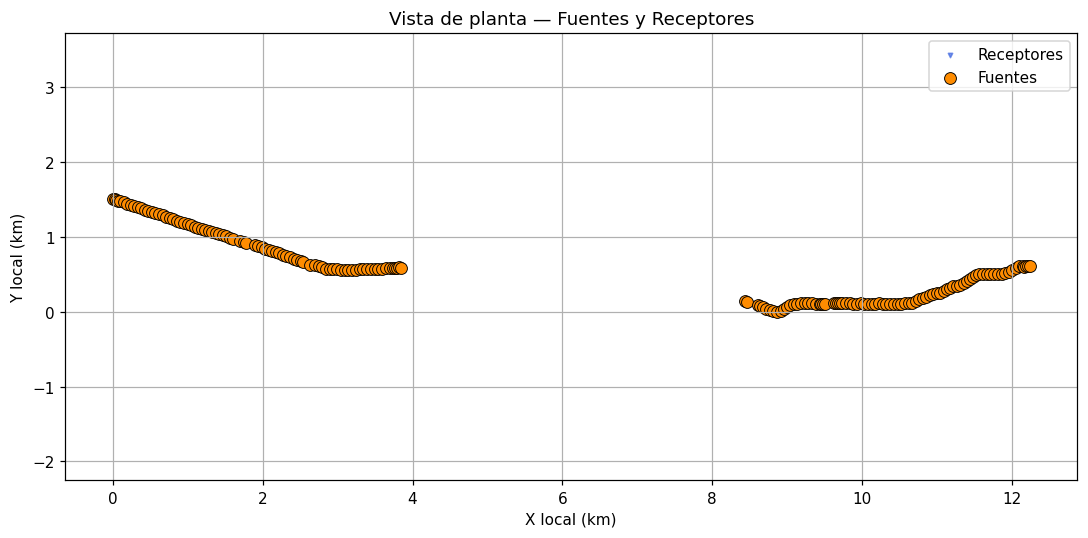

In [ ]:
import os, glob
import numpy as np
import matplotlib.pyplot as plt
from obspy.io.segy.segy import _read_segy

GEOM_DIR = "/home/pc-2/Documents/CAVE_minciencias/final_model/shots_reales_raw"
sgy_files = sorted(glob.glob(os.path.join(GEOM_DIR, "*.sgy")))
if not sgy_files:
    raise FileNotFoundError(f"No encontré archivos .sgy en {GEOM_DIR}")

print(">>> Archivos SGY encontrados:")
for f in sgy_files:
    print("   -", os.path.basename(f))

def apply_scalar(val, scal):
    """Aplica el scalar SEG-Y a una coordenada."""
    if val is None:
        return None
    if scal is None or scal == 0:
        return float(val)
    scal = float(scal)
    if scal > 0:
        return float(val) * scal
    else:
        return float(val) / abs(scal)

src_xy_all, rec_xy_all = [], []

for f in sgy_files:
    print(f"\n>>> Leyendo geometría de: {os.path.basename(f)}")
    segy = _read_segy(f)

    for tr in segy.traces:
        h = tr.header

        scal = getattr(h, "scalar_to_be_applied_to_all_coordinates", 1)

        sx_raw = getattr(h, "source_coordinate_x", None)
        sy_raw = getattr(h, "source_coordinate_y", None)
        gx_raw = getattr(h, "group_coordinate_x", None)
        gy_raw = getattr(h, "group_coordinate_y", None)

        sx = apply_scalar(sx_raw, scal) if sx_raw is not None else None
        sy = apply_scalar(sy_raw, scal) if sy_raw is not None else None
        gx = apply_scalar(gx_raw, scal) if gx_raw is not None else None
        gy = apply_scalar(gy_raw, scal) if gy_raw is not None else None

        if sx is not None and sy is not None and (sx != 0 or sy != 0):
            src_xy_all.append((sx, sy))
        if gx is not None and gy is not None and (gx != 0 or gy != 0):
            rec_xy_all.append((gx, gy))

src_xy_all = np.array(src_xy_all, dtype=float)
rec_xy_all = np.array(rec_xy_all, dtype=float)

# Únicos
src_xy = np.unique(src_xy_all, axis=0)
rec_xy = np.unique(rec_xy_all, axis=0)

print(f"\n>>> Fuentes únicas totales:    {src_xy.shape[0]}")
print(f">>> Receptores únicos totales: {rec_xy.shape[0]}")

def to_local(xy):
    if xy.size == 0:
        return xy
    x = xy[:, 0] - np.min(xy[:, 0])
    y = xy[:, 1] - np.min(xy[:, 1])
    x /= 1000.0
    y /= 1000.0
    return np.column_stack([x, y])

src_loc = to_local(src_xy)
rec_loc = to_local(rec_xy)

print("\nRango fuentes (local, km):")
if src_loc.size:
    print("  X:", src_loc[:,0].min(), "→", src_loc[:,0].max())
    print("  Y:", src_loc[:,1].min(), "→", src_loc[:,1].max())

print("Rango receptores (local, km):")
if rec_loc.size:
    print("  X:", rec_loc[:,0].min(), "→", rec_loc[:,0].max())
    print("  Y:", rec_loc[:,1].min(), "→", rec_loc[:,1].max())

plt.figure(figsize=(10, 5))

if rec_loc.size:
    plt.scatter(
        rec_loc[:, 0], rec_loc[:, 1],
        s=8, marker="v",
        color="royalblue",
        alpha=0.7,
        label="Receptores"
    )

if src_loc.size:
    plt.scatter(
        src_loc[:, 0], src_loc[:, 1],
        s=60, marker="o",
        color="darkorange",
        edgecolors="black",
        linewidths=0.6,
        alpha=1,
        label="Fuentes"
    )

plt.xlabel("X local (km)")
plt.ylabel("Y local (km)")
plt.title("Vista de planta — Fuentes y Receptores")

plt.legend()
plt.grid(True)
plt.axis("equal")

allY = np.concatenate([src_loc[:,1], rec_loc[:,1]])
ymin = np.percentile(allY, 5)
ymax = np.percentile(allY, 95)
plt.ylim(ymin, ymax)

allX = np.concatenate([src_loc[:,0], rec_loc[:,0]])
xmin = np.percentile(allX, 2)
xmax = np.percentile(allX, 98)
plt.xlim(xmin, xmax)

plt.tight_layout()
plt.show()




In [ ]:
import os, glob, json, csv, re, numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch, torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from pytorch_msssim import SSIM
from skimage.metrics import structural_similarity as ssim
from obspy.io.segy.segy import _read_segy

NPY_DIR  = "/home/pc-2/Documents/CAVE_minciencias/final_model/shots_reales_finales2D"

GEOM_DIR = "/home/pc-2/Documents/CAVE_minciencias/final_model/shots_reales_raw"

BASE_DIR = NPY_DIR
OUT_DIR  = os.path.join(BASE_DIR, "salidas_crg_shotmask_ste_multi")
os.makedirs(OUT_DIR, exist_ok=True)

GLOBAL_SEED = 42
np.random.seed(GLOBAL_SEED)
torch.manual_seed(GLOBAL_SEED)
plt.rcParams["figure.dpi"] = 110

EPOCHS = 200
BATCH  = 1
LR     = 1e-4
LAMBDA_SPARSITY = 0.01
SCENARIOS = list(range(10, 100, 10))  # 10,20,...,90
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

npy_files = sorted(glob.glob(os.path.join(NPY_DIR, "*.npy")))
if not npy_files:
    raise FileNotFoundError(f"No hay archivos .npy en {NPY_DIR}")

print(">>> Shots .npy encontrados:")
for f in npy_files:
    print("   -", os.path.basename(f))

def key_from_npy(path):
    base = os.path.basename(path)
    return base.replace("_trim7.npy", "")

def key_from_sgy(path):
    base = os.path.basename(path)
    return base.replace(".sgy", "")

keys_npy = [key_from_npy(f) for f in npy_files]

sgy_files_geom = sorted(glob.glob(os.path.join(GEOM_DIR, "*.sgy")))
if not sgy_files_geom:
    raise FileNotFoundError(f"No hay archivos .sgy en {GEOM_DIR}")

print("\n>>> Archivos SGY (geom) encontrados:")
for f in sgy_files_geom:
    print("   -", os.path.basename(f))

def apply_scalar(val, scal):
    """Aplica el scalar SEG-Y a una coordenada."""
    if val is None:
        return None
    if scal is None or scal == 0:
        return float(val)
    scal = float(scal)
    if scal > 0:
        return float(val) * scal
    else:
        return float(val) / abs(scal)

geom_src_raw = {}
rec_xy_all_raw = []

for f in sgy_files_geom:
    segy = _read_segy(f)
    key = key_from_sgy(f)

    sx_list = []
    for tr in segy.traces:
        h = tr.header
        scal = getattr(h, "scalar_to_be_applied_to_all_coordinates", 1)

        sx_raw = getattr(h, "source_coordinate_x", None)
        sy_raw = getattr(h, "source_coordinate_y", None)
        gx_raw = getattr(h, "group_coordinate_x", None)
        gy_raw = getattr(h, "group_coordinate_y", None)

        sx = apply_scalar(sx_raw, scal) if sx_raw is not None else None
        sy = apply_scalar(sy_raw, scal) if sy_raw is not None else None
        gx = apply_scalar(gx_raw, scal) if gx_raw is not None else None
        gy = apply_scalar(gy_raw, scal) if gy_raw is not None else None

        if sx is not None and sy is not None and (sx != 0 or sy != 0):
            sx_list.append((sx, sy))
        if gx is not None and gy is not None and (gx != 0 or gy != 0):
            rec_xy_all_raw.append((gx, gy))

    if sx_list and key not in geom_src_raw:
        geom_src_raw[key] = sx_list[0]

src_xy_raw = []
missing_keys = []
for k in keys_npy:
    if k in geom_src_raw:
        src_xy_raw.append(geom_src_raw[k])
    else:
        missing_keys.append(k)

if missing_keys:
    print("\n>>> ADVERTENCIA: no encontré geometría para estos shots (keys npy):")
    for k in missing_keys:
        print("   -", k)

src_xy_raw = np.array(src_xy_raw, dtype=float)
rec_xy_all_raw = np.array(rec_xy_all_raw, dtype=float)
rec_xy = np.unique(rec_xy_all_raw, axis=0)

def to_local(xy):
    if xy.size == 0:
        return xy
    x = xy[:, 0] - np.min(xy[:, 0])
    y = xy[:, 1] - np.min(xy[:, 1])
    x /= 1000.0
    y /= 1000.0
    return np.column_stack([x, y])

SRC_LOC = to_local(src_xy_raw)
REC_LOC = to_local(rec_xy)

print(f"\n>>> Fuentes con geometría alineada: {SRC_LOC.shape[0]} (de {len(npy_files)} .npy)")
print(f">>> Receptores únicos: {REC_LOC.shape[0]}")

def norm_trace_lastaxis(x):
    m = np.max(np.abs(x), axis=-1, keepdims=True) + 1e-6
    return x / m

def load_all_npy(base_dir):
    files = sorted(glob.glob(os.path.join(base_dir, "*.npy")))
    if not files:
        raise FileNotFoundError("No hay archivos .npy en la carpeta.")
    arrays, paths = [], []
    for f in files:
        A = np.load(f)
        if A.ndim != 2:
            raise ValueError(f"{os.path.basename(f)}: se esperaba 2D, obtenido {A.shape}")
        r, t = A.shape
        shot = A.astype(np.float32, copy=False) if t >= r else A.T.astype(np.float32, copy=False)
        arrays.append(shot); paths.append(f)
    return arrays, paths

def unify_shapes(shots_list, target=None, mode="center"):
    Rs = [s.shape[0] for s in shots_list]
    Ts = [s.shape[1] for s in shots_list]
    if target is None:
        H, W = min(Rs), min(Ts)
    else:
        H, W = target
    def crop2d(x, H, W, mode="center"):
        r, t = x.shape
        if r < H or t < W:
            raise ValueError(f"Shot {x.shape} más pequeño que el target {(H,W)}.")
        if mode == "center":
            rs = (r - H)//2; ts = (t - W)//2
        else:
            rs, ts = 0, 0
        return x[rs:rs+H, ts:ts+W].copy()
    X = np.stack([crop2d(s, H, W, mode=mode) for s in shots_list], 0)
    return X, (H, W)

def crop_ST_mult8(arr):
    H, S, T = arr.shape
    S8, T8 = (S // 8) * 8, (T // 8) * 8
    if S8 != S or T8 != T:
        arr = arr[:, :S8, :T8].copy()
    return arr

def save_np(path, arr):
    np.save(path, arr)

print("\n>>> Cargando .npy de reconstrucción ...")
shots_list, file_list = load_all_npy(BASE_DIR)
N = len(shots_list)
print(f">>> Cargados {N} shots .npy")

gathers_shot, (Hc, Wc) = unify_shapes(shots_list, target=None, mode="center")
H8, W8 = (Hc // 8) * 8, (Wc // 8) * 8
if (H8 != Hc) or (W8 != Wc):
    gathers_shot = np.ascontiguousarray(gathers_shot[:, :H8, :W8])
    Hc, Wc = H8, W8
assert Hc % 8 == 0 and Wc % 8 == 0

gathers_shot = norm_trace_lastaxis(gathers_shot).astype(np.float32)

CRG_all = np.transpose(gathers_shot, (1, 0, 2)).copy()
H, S, T = CRG_all.shape
print(f">>> CRG_all: (H={H}, S={S}, T={T})")

if SRC_LOC.shape[0] != S:
    print(f"\n>>> OJO: S={S} shots en datos pero {SRC_LOC.shape[0]} fuentes con geometría.")
    print(">>> Asegúrate de que coinciden los archivos .npy y .sgy.")

idx_rec = np.arange(H)
idx_tr, idx_te = train_test_split(idx_rec, test_size=0.2, random_state=GLOBAL_SEED, shuffle=True)
CRG_tr, CRG_te = CRG_all[idx_tr], CRG_all[idx_te]

CRG_all = crop_ST_mult8(CRG_all)
CRG_tr  = crop_ST_mult8(CRG_tr)
CRG_te  = crop_ST_mult8(CRG_te)
H_all, S_all, T_all = CRG_all.shape
H_tr,  S_tr,  T_tr  = CRG_tr.shape
H_te,  S_te,  T_te  = CRG_te.shape
assert S_tr == S_all == S_te and T_tr == T_all == T_te
print(">>> Shapes tras hotfix:",
      "CRG_all", CRG_all.shape,
      "CRG_tr",  CRG_tr.shape,
      "CRG_te",  CRG_te.shape)

class UNet2DFull(nn.Module):
    def __init__(self):
        super().__init__()
        def blk(cin, cout):
            return nn.Sequential(
                nn.Conv2d(cin, cout, 3, padding=1),
                nn.BatchNorm2d(cout), nn.LeakyReLU(0.01, True),
                nn.Conv2d(cout, cout, 3, padding=1),
                nn.BatchNorm2d(cout), nn.LeakyReLU(0.01, True)
            )
        self.e1, self.p1 = blk(1,64), nn.MaxPool2d(2,2)
        self.e2, self.p2 = blk(64,128), nn.MaxPool2d(2,2)
        self.e3, self.p3 = blk(128,256), nn.MaxPool2d(2,2)
        self.bott = blk(256,512)
        self.u3 = nn.ConvTranspose2d(512,256,2,2); self.d3 = blk(512,256)
        self.u2 = nn.ConvTranspose2d(256,128,2,2); self.d2 = blk(256,128)
        self.u1 = nn.ConvTranspose2d(128, 64,2,2); self.d1 = blk(128, 64)
        self.out = nn.Conv2d(64,1,1)
    def forward(self,x):
        e1=self.e1(x); p1=self.p1(e1)
        e2=self.e2(p1); p2=self.p2(e2)
        e3=self.e3(p2); p3=self.p3(e3)
        b=self.bott(p3)
        u3=self.u3(b); d3=self.d3(torch.cat([u3, self.crop(e3,u3)],1))
        u2=self.u2(d3); d2=self.d2(torch.cat([u2, self.crop(e2,u2)],1))
        u1=self.u1(d2); d1=self.d1(torch.cat([u1, self.crop(e1,u1)],1))
        return torch.tanh(self.out(d1))
    @staticmethod
    def crop(a,b):
        _,_,h,w=b.shape; _,_,H,W=a.shape
        dh,dw=(H-h)//2,(W-w)//2
        return a[:,:,dh:dh+h, dw:dw+w]

class BinaryShotMaskSTE(nn.Module):
    def __init__(self, n_shots, init_keep_prob=0.5):
        super().__init__()
        self.n_shots = int(n_shots)
        init_keep_prob = float(np.clip(init_keep_prob, 1e-3, 1-1e-3))
        init_logit = np.log(init_keep_prob/(1-init_keep_prob))
        self.logits = nn.Parameter(torch.full((self.n_shots,), float(init_logit)))
        self.frac_remove = 0.5
    def set_frac_remove(self, frac):
        self.frac_remove = float(np.clip(frac, 0.0, 1.0))
    def forward(self, x):
        assert x.dim()==4 and x.shape[2]==self.n_shots, f"Esperaba S={self.n_shots}, got {x.shape}"
        probs = torch.sigmoid(self.logits)                 # (S,)
        K = int(round(self.frac_remove * self.n_shots))
        if K > 0:
            idx_del = torch.topk(probs, K, largest=False).indices
            hard = torch.ones_like(probs); hard[idx_del] = 0.0
        else:
            hard = torch.ones_like(probs)
        ste_mask = hard + probs - probs.detach()           # STE
        x_masked = x * ste_mask.view(1,1,self.n_shots,1)
        return x_masked, probs, hard
    @torch.no_grad()
    def hard_indices_removed(self):
        probs = torch.sigmoid(self.logits)
        K = int(round(self.frac_remove * self.n_shots))
        if K <= 0: return np.array([], dtype=int)
        idx_del = torch.topk(probs, K, largest=False).indices
        return idx_del.cpu().numpy()

def train_quick(CRG_tr, pct, epochs=EPOCHS, batch=BATCH, lr=LR, lambda_sp=LAMBDA_SPARSITY):
    H, S, T = CRG_tr.shape
    assert S % 8 == 0 and T % 8 == 0, f"(S,T)=({S},{T}) deben ser múltiplos de 8"
    target_keep = 1.0 - (pct/100.0)

    Xt = torch.from_numpy(CRG_tr).unsqueeze(1).to(device)
    loader = DataLoader(TensorDataset(Xt, Xt), batch_size=batch, shuffle=True)

    model = UNet2DFull().to(device)
    mask_layer = BinaryShotMaskSTE(n_shots=S, init_keep_prob=target_keep).to(device)
    mask_layer.set_frac_remove(pct/100.0)

    opt = torch.optim.Adam([
        {"params": model.parameters(), "lr": lr},
        {"params": mask_layer.parameters(), "lr": lr}
    ])
    crit = SSIM(data_range=2.0, size_average=True, channel=1)

    loss_hist = []
    model.train()
    for ep in range(1, epochs+1):
        run = 0.0
        for xb, yb in loader:
            opt.zero_grad(set_to_none=True)
            xb_masked, probs, hard = mask_layer(xb)
            yp = model(xb_masked)
            loss_rec = 1.0 - crit(yp, yb)
            keep_mean = torch.sigmoid(mask_layer.logits).mean()
            loss_sp = (keep_mean - target_keep) ** 2
            loss = loss_rec + lambda_sp * loss_sp
            loss.backward(); opt.step()
            run += float(loss.item())
        loss_hist.append(run / len(loader))
        print(f"[PCT={pct:02d} | E{ep:03d}] loss={loss_hist[-1]:.4f} | keep_mean≈{float(keep_mean):.3f}")
    return model, mask_layer, loss_hist

def eval_removed_only(model, CRG_te, removed_idx, binf=4):
    if len(removed_idx) == 0:
        return {"MSE": None, "PSNR": None, "SSIM": None, "SNR": None}
    model.eval()
    Htot, S, T = CRG_te.shape
    MSE, PSNR, SSIMg, SNR = [], [], [], []
    with torch.no_grad():
        for i0 in range(0, Htot, binf):
            i1 = min(i0+binf, Htot)
            xb_cpu = CRG_te[i0:i1].copy()
            xb_cpu[:, removed_idx, :] = 0.0
            xb = torch.from_numpy(xb_cpu).unsqueeze(1).to(device)
            yp = model(xb).squeeze(1).cpu().numpy()
            yt = CRG_te[i0:i1]
            for b in range(yp.shape[0]):
                ypn = yp[b, removed_idx]
                ytn = yt[b, removed_idx]
                mse = np.mean((ytn - ypn)**2)
                amp = np.ptp(ytn) + 1e-8
                psn = 20*np.log10(amp / (np.sqrt(mse + 1e-12))) if mse > 0 else float('inf')
                ssi = np.mean([ssim(ytn[j], ypn[j], data_range=2) for j in range(ytn.shape[0])])
                snr = 10*np.log10((np.mean(ytn**2)+1e-12)/(mse+1e-12))
                MSE.append(mse); PSNR.append(psn); SSIMg.append(ssi); SNR.append(snr)
    mean = lambda v: float(np.mean(v)) if len(v) else None
    return {"MSE": mean(MSE), "PSNR": mean(PSNR), "SSIM": mean(SSIMg), "SNR": mean(SNR)}

def save_mask_bars_and_array(removed_idx, S, save_stub, title=None, height=40):
    mask = np.ones(S, dtype=np.float32); mask[removed_idx] = 0.0
    img = np.ones((height, S), dtype=np.float32); img[:, mask == 0] = 0.0
    fig = plt.figure(figsize=(12, 2.2))
    ax = fig.add_subplot(1,1,1)
    ax.imshow(img, cmap="gray", aspect="auto", origin="upper", vmin=0, vmax=1)
    ax.set_yticks([]); ax.set_xlabel("Shot (índice)")
    ax.set_title(title if title else "Máscara de shots (1 keep / 0 removed)")
    fig.tight_layout(); fig.savefig(save_stub + "_mask_bars.png", dpi=140); plt.close(fig)
    save_np(save_stub + "_mask_bars.npy", img)
    return img

def viz_one_shot_and_arrays(model, removed_idx, CRG_all, shot_idx, save_dir, stub, vmin=-1, vmax=1, binf=4):
    os.makedirs(save_dir, exist_ok=True)
    model.eval()
    Htot, S, T = CRG_all.shape
    pred = np.zeros((Htot, T), dtype=np.float32)
    real = CRG_all[:, shot_idx, :].copy()
    with torch.no_grad():
        for i0 in range(0, Htot, binf):
            i1 = min(i0+binf, Htot)
            xb_cpu = CRG_all[i0:i1].copy()
            if len(removed_idx) > 0:
                xb_cpu[:, removed_idx, :] = 0.0
            xb = torch.from_numpy(xb_cpu).unsqueeze(1).to(device)
            yb = model(xb).squeeze(1).cpu().numpy()
            pred[i0:i1, :] = yb[:, shot_idx, :]
    err = np.abs(pred - real)

    fig = plt.figure(figsize=(16, 4.2))
    ax1 = fig.add_subplot(1,3,1); im0 = ax1.imshow(pred.T, cmap='gray', aspect='auto', vmin=vmin, vmax=vmax)
    ax1.set_title(f"Predicho — Shot {shot_idx}"); ax1.set_xlabel("Receptor"); ax1.set_ylabel("Tiempo")
    fig.colorbar(im0, ax=ax1, fraction=0.046, pad=0.04)
    ax2 = fig.add_subplot(1,3,2); im1 = ax2.imshow(real.T, cmap='gray', aspect='auto', vmin=vmin, vmax=vmax)
    ax2.set_title(f"Real — Shot {shot_idx}"); ax2.set_xlabel("Receptor"); ax2.set_ylabel("Tiempo")
    fig.colorbar(im1, ax=ax2, fraction=0.046, pad=0.04)
    ax3 = fig.add_subplot(1,3,3); im2 = ax3.imshow(err.T, cmap='inferno', aspect='auto')
    ax3.set_title("Error absoluto"); ax3.set_xlabel("Receptor"); ax3.set_ylabel("Tiempo")
    fig.colorbar(im2, ax=ax3, fraction=0.046, pad=0.04)
    fig.tight_layout(); fig.savefig(os.path.join(save_dir, f"{stub}_maps.png"), dpi=140); plt.close(fig)

    recs = np.linspace(0, pred.shape[0]-1, num=3, dtype=int)
    t = np.arange(pred.shape[1])
    fig2 = plt.figure(figsize=(12,3.6))
    for k, r in enumerate(recs):
        ax = fig2.add_subplot(1,3,k+1)
        ax.plot(t, real[r], label="Real", linewidth=1.2)
        ax.plot(t, pred[r], label="Predicho", linewidth=1.0)
        ax.set_title(f"Rec {r}"); ax.set_xlabel("Tiempo"); ax.set_ylabel("Amp"); ax.grid(True)
        if k==0: ax.legend()
    fig2.tight_layout(); fig2.savefig(os.path.join(save_dir, f"{stub}_traces.png"), dpi=140); plt.close(fig2)

    save_np(os.path.join(save_dir, f"{stub}_pred.npy"), pred)
    save_np(os.path.join(save_dir, f"{stub}_real.npy"), real)
    save_np(os.path.join(save_dir, f"{stub}_err.npy"),  err)
    save_np(os.path.join(save_dir, f"{stub}_traces_idx.npy"), recs)

def plot_shotmap_scenario(src_loc, rec_loc, removed_idx, save_path, pct):
    removed_idx = np.asarray(removed_idx, dtype=int)
    n_src = src_loc.shape[0]
    removed_idx = removed_idx[(removed_idx >= 0) & (removed_idx < n_src)]
    all_idx = np.arange(n_src, dtype=int)
    keep_idx = np.setdiff1d(all_idx, removed_idx)

    plt.figure(figsize=(10, 5))

    if rec_loc.size:
        plt.scatter(
            rec_loc[:, 0], rec_loc[:, 1],
            s=8, marker="v",
            color="lightgray",
            alpha=0.6,
            label="Receptores"
        )

    if keep_idx.size:
        plt.scatter(
            src_loc[keep_idx, 0], src_loc[keep_idx, 1],
            s=60, marker="o",
            facecolors="white",
            edgecolors="black",
            linewidths=0.8,
            alpha=1.0,
            label="Shots activos"
        )

    if removed_idx.size:
        plt.scatter(
            src_loc[removed_idx, 0], src_loc[removed_idx, 1],
            s=60, marker="o",
            facecolors="black",
            edgecolors="black",
            linewidths=0.8,
            alpha=1.0,
            label="Shots submuestreados"
        )

    plt.xlabel("X local (km)")
    plt.ylabel("Y local (km)")
    plt.title(f"Mapa en planta — {pct}% shots eliminados")

    plt.legend()
    plt.grid(True)
    plt.axis("equal")

    allX = src_loc[:, 0]
    allY = src_loc[:, 1]
    xmin, xmax = np.percentile(allX, [2, 98])
    ymin, ymax = np.percentile(allY, [5, 95])
    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)

    plt.tight_layout()
    plt.savefig(save_path, dpi=160)
    plt.close()


all_loss_hist = {}
metrics_rows = []
print("\n>>> Ejecutando escenarios:", SCENARIOS)

for PCT in SCENARIOS:
    print("\n" + "="*70)
    print(f">>> Entrenando escenario {PCT}% shots eliminados")
    sc_dir = os.path.join(OUT_DIR, f"pct_{PCT:02d}")
    os.makedirs(sc_dir, exist_ok=True)

    model, mask_layer, loss_hist = train_quick(CRG_tr, pct=PCT)
    all_loss_hist[PCT] = loss_hist
    save_np(os.path.join(sc_dir, "loss_hist.npy"), np.array(loss_hist, dtype=np.float32))

    removed_idx = mask_layer.hard_indices_removed()
    S_tot = CRG_all.shape[1]
    print(f">>> Shots eliminados (duros): {len(removed_idx)} de {S_tot}")

    shotmap_path = os.path.join(sc_dir, f"shotmap_pct_{PCT:02d}.png")
    plot_shotmap_scenario(SRC_LOC, REC_LOC, removed_idx, shotmap_path, PCT)

    mask_stub = os.path.join(sc_dir, "mask")
    _ = save_mask_bars_and_array(removed_idx, S_tot, mask_stub,
                                 title=f"Máscara — {PCT}% eliminados")
    save_np(os.path.join(sc_dir, "removed_idx.npy"), removed_idx.astype(np.int32))

    metrics = eval_removed_only(model, CRG_te, removed_idx, binf=4)
    with open(os.path.join(sc_dir, "metrics.json"), "w") as f:
        json.dump(metrics, f, indent=2)
    print(">>> Métricas (solo shots eliminados en TEST):", metrics)

    for s in removed_idx[:2]:
        viz_one_shot_and_arrays(model, removed_idx, CRG_all, s,
                                save_dir=sc_dir, stub=f"shot_{s}")

    plt.figure(figsize=(6,4))
    plt.plot(range(1,len(loss_hist)+1), loss_hist)
    plt.title(f"Pérdida (1-SSIM + λ·sparsity) — {PCT}%")
    plt.xlabel("Época"); plt.ylabel("Loss"); plt.grid(True); plt.tight_layout()
    plt.savefig(os.path.join(sc_dir, f"loss_curve_{PCT:02d}.png"), dpi=140); plt.close()

    metrics_rows.append({
        "pct_removed": PCT,
        "num_removed": int(len(removed_idx)),
        "S_total": int(S_tot),
        "MSE": metrics["MSE"],
        "PSNR": metrics["PSNR"],
        "SSIM": metrics["SSIM"],
        "SNR": metrics["SNR"]
    })

plt.figure(figsize=(8,5))
for PCT in SCENARIOS:
    plt.plot(range(1, len(all_loss_hist[PCT])+1), all_loss_hist[PCT], label=f"{PCT}%")
plt.title("Curvas de pérdida por escenario (1-SSIM + λ·sparsity)")
plt.xlabel("Época"); plt.ylabel("Loss"); plt.grid(True)
plt.legend(ncol=3, fontsize=9)
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "loss_curves_all.png"), dpi=160)
plt.close()

np.save(os.path.join(OUT_DIR, "all_loss_hist.npy"),
        np.array([ (pct, np.array(all_loss_hist[pct], dtype=np.float32)) for pct in SCENARIOS ], dtype=object),
        allow_pickle=True)

csv_path = os.path.join(OUT_DIR, "metrics_by_pct.csv")
with open(csv_path, "w", newline="") as f:
    w = csv.DictWriter(f, fieldnames=["pct_removed","num_removed","S_total","MSE","PSNR","SSIM","SNR"])
    w.writeheader(); w.writerows(metrics_rows)

print("\n>>> FIN. Salidas principales en:", OUT_DIR)
print(" - loss_curves_all.png")
print(" - all_loss_hist.npy")
print(" - metrics_by_pct.csv")
print(" - pct_xx/* (pérdidas, máscara PNG/NPY, shotmap_pct_xx.png, índices, métricas, preds/real/err)")


>>> Shots .npy encontrados:
   - 100_1511555540_30100_63700_20171127_150424_100_trim7.npy
   - 101_1511555633_30100_63900_20171127_150424_178_trim7.npy
   - 102_1511555730_30100_64100_20171127_150424_349_trim7.npy
   - 103_1511555824_30100_64300_20171127_150424_380_trim7.npy
   - 104_1511555917_30100_64500_20171127_150424_505_trim7.npy
   - 105_1511556023_30100_64700_20171127_150424_614_trim7.npy
   - 106_1511556123_30100_64900_20171127_150424_739_trim7.npy
   - 107_1511556216_30100_65100_20171127_150424_880_trim7.npy
   - 108_1511556332_30100_65300_20171127_150425_067_trim7.npy
   - 110_1511556750_30100_65500_20171127_150425_192_trim7.npy
   - 111_1511556843_30100_65700_20171127_150425_270_trim7.npy
   - 115_1511562457_30100_66100_20171127_150425_472_trim7.npy
   - 116_1511562556_30100_66000_20171127_150425_566_trim7.npy
   - 117_1511562646_30100_65900_20171127_150425_784_trim7.npy
   - 118_1511562782_30100_65800_20171127_150425_862_trim7.npy
   - 120_1511564038_30100_55700_20171127_1

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


[PCT=10 | E200] loss=0.0968 | keep_mean≈0.946
>>> Shots eliminados (duros): 16 de 160
>>> Métricas (solo shots eliminados en TEST): {'MSE': 0.032333388924598694, 'PSNR': 21.043842315673828, 'SSIM': 0.3127256665855106, 'SNR': 0.12240459024906158}

>>> Entrenando escenario 20% shots eliminados
[PCT=20 | E001] loss=0.4289 | keep_mean≈0.801
[PCT=20 | E002] loss=0.2233 | keep_mean≈0.802
[PCT=20 | E003] loss=0.2048 | keep_mean≈0.802
[PCT=20 | E004] loss=0.1990 | keep_mean≈0.803
[PCT=20 | E005] loss=0.1993 | keep_mean≈0.804
[PCT=20 | E006] loss=0.1992 | keep_mean≈0.805
[PCT=20 | E007] loss=0.1936 | keep_mean≈0.806
[PCT=20 | E008] loss=0.1963 | keep_mean≈0.806
[PCT=20 | E009] loss=0.1962 | keep_mean≈0.807
[PCT=20 | E010] loss=0.1926 | keep_mean≈0.808
[PCT=20 | E011] loss=0.1935 | keep_mean≈0.809
[PCT=20 | E012] loss=0.1967 | keep_mean≈0.809
[PCT=20 | E013] loss=0.1939 | keep_mean≈0.810
[PCT=20 | E014] loss=0.1952 | keep_mean≈0.811
[PCT=20 | E015] loss=0.1952 | keep_mean≈0.812
[PCT=20 | E016] l

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


[PCT=20 | E200] loss=0.1605 | keep_mean≈0.910
>>> Shots eliminados (duros): 32 de 160
>>> Métricas (solo shots eliminados en TEST): {'MSE': 0.02861693874001503, 'PSNR': 21.642078399658203, 'SSIM': 0.3326965366497329, 'SNR': 0.5642499923706055}

>>> Entrenando escenario 30% shots eliminados
[PCT=30 | E001] loss=0.5145 | keep_mean≈0.701
[PCT=30 | E002] loss=0.3273 | keep_mean≈0.703
[PCT=30 | E003] loss=0.3071 | keep_mean≈0.704
[PCT=30 | E004] loss=0.2991 | keep_mean≈0.705
[PCT=30 | E005] loss=0.2941 | keep_mean≈0.707
[PCT=30 | E006] loss=0.2907 | keep_mean≈0.708
[PCT=30 | E007] loss=0.2923 | keep_mean≈0.709
[PCT=30 | E008] loss=0.2936 | keep_mean≈0.710
[PCT=30 | E009] loss=0.2895 | keep_mean≈0.712
[PCT=30 | E010] loss=0.2884 | keep_mean≈0.713
[PCT=30 | E011] loss=0.2913 | keep_mean≈0.714
[PCT=30 | E012] loss=0.2880 | keep_mean≈0.715
[PCT=30 | E013] loss=0.2884 | keep_mean≈0.717
[PCT=30 | E014] loss=0.2874 | keep_mean≈0.718
[PCT=30 | E015] loss=0.2889 | keep_mean≈0.719
[PCT=30 | E016] los

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


[PCT=30 | E200] loss=0.2387 | keep_mean≈0.876
>>> Shots eliminados (duros): 48 de 160
>>> Métricas (solo shots eliminados en TEST): {'MSE': 0.02840171568095684, 'PSNR': 21.64581298828125, 'SSIM': 0.34694566019762346, 'SNR': 0.7164191603660583}

>>> Entrenando escenario 40% shots eliminados
[PCT=40 | E001] loss=0.5183 | keep_mean≈0.602
[PCT=40 | E002] loss=0.3833 | keep_mean≈0.603
[PCT=40 | E003] loss=0.3826 | keep_mean≈0.605
[PCT=40 | E004] loss=0.3747 | keep_mean≈0.607
[PCT=40 | E005] loss=0.3726 | keep_mean≈0.609
[PCT=40 | E006] loss=0.3726 | keep_mean≈0.611
[PCT=40 | E007] loss=0.3695 | keep_mean≈0.612
[PCT=40 | E008] loss=0.3713 | keep_mean≈0.614
[PCT=40 | E009] loss=0.3681 | keep_mean≈0.616
[PCT=40 | E010] loss=0.3722 | keep_mean≈0.617
[PCT=40 | E011] loss=0.3685 | keep_mean≈0.619
[PCT=40 | E012] loss=0.3674 | keep_mean≈0.621
[PCT=40 | E013] loss=0.3685 | keep_mean≈0.623
[PCT=40 | E014] loss=0.3708 | keep_mean≈0.624
[PCT=40 | E015] loss=0.3664 | keep_mean≈0.626
[PCT=40 | E016] los

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


[PCT=40 | E200] loss=0.3037 | keep_mean≈0.845
>>> Shots eliminados (duros): 64 de 160
>>> Métricas (solo shots eliminados en TEST): {'MSE': 0.030881710350513458, 'PSNR': 21.202457427978516, 'SSIM': 0.3249127934438079, 'SNR': 0.631844699382782}

>>> Entrenando escenario 50% shots eliminados
[PCT=50 | E001] loss=0.6391 | keep_mean≈0.502
[PCT=50 | E002] loss=0.4839 | keep_mean≈0.504
[PCT=50 | E003] loss=0.4542 | keep_mean≈0.506
[PCT=50 | E004] loss=0.4552 | keep_mean≈0.508
[PCT=50 | E005] loss=0.4536 | keep_mean≈0.510
[PCT=50 | E006] loss=0.4482 | keep_mean≈0.512
[PCT=50 | E007] loss=0.4439 | keep_mean≈0.514
[PCT=50 | E008] loss=0.4484 | keep_mean≈0.516
[PCT=50 | E009] loss=0.4492 | keep_mean≈0.518
[PCT=50 | E010] loss=0.4483 | keep_mean≈0.520
[PCT=50 | E011] loss=0.4432 | keep_mean≈0.522
[PCT=50 | E012] loss=0.4400 | keep_mean≈0.524
[PCT=50 | E013] loss=0.4466 | keep_mean≈0.526
[PCT=50 | E014] loss=0.4455 | keep_mean≈0.528
[PCT=50 | E015] loss=0.4455 | keep_mean≈0.530
[PCT=50 | E016] los

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


[PCT=50 | E200] loss=0.4021 | keep_mean≈0.803
>>> Shots eliminados (duros): 80 de 160
>>> Métricas (solo shots eliminados en TEST): {'MSE': 0.030452098697423935, 'PSNR': 21.285633087158203, 'SSIM': 0.3314016276235034, 'SNR': 0.5585347414016724}

>>> Entrenando escenario 60% shots eliminados
[PCT=60 | E001] loss=0.5994 | keep_mean≈0.402
[PCT=60 | E002] loss=0.5282 | keep_mean≈0.404
[PCT=60 | E003] loss=0.5156 | keep_mean≈0.406
[PCT=60 | E004] loss=0.5175 | keep_mean≈0.408
[PCT=60 | E005] loss=0.5155 | keep_mean≈0.411
[PCT=60 | E006] loss=0.5174 | keep_mean≈0.413
[PCT=60 | E007] loss=0.5165 | keep_mean≈0.415
[PCT=60 | E008] loss=0.5136 | keep_mean≈0.417
[PCT=60 | E009] loss=0.5156 | keep_mean≈0.419
[PCT=60 | E010] loss=0.5130 | keep_mean≈0.421
[PCT=60 | E011] loss=0.5108 | keep_mean≈0.423
[PCT=60 | E012] loss=0.5113 | keep_mean≈0.425
[PCT=60 | E013] loss=0.5124 | keep_mean≈0.428
[PCT=60 | E014] loss=0.5119 | keep_mean≈0.430
[PCT=60 | E015] loss=0.5119 | keep_mean≈0.432
[PCT=60 | E016] lo

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


[PCT=60 | E200] loss=0.4549 | keep_mean≈0.738
>>> Shots eliminados (duros): 96 de 160
>>> Métricas (solo shots eliminados en TEST): {'MSE': 0.041677262634038925, 'PSNR': 19.910381317138672, 'SSIM': 0.28713596420485016, 'SNR': -0.5153358578681946}

>>> Entrenando escenario 70% shots eliminados
[PCT=70 | E001] loss=0.7089 | keep_mean≈0.302
[PCT=70 | E002] loss=0.6032 | keep_mean≈0.304
[PCT=70 | E003] loss=0.5969 | keep_mean≈0.306
[PCT=70 | E004] loss=0.5904 | keep_mean≈0.308
[PCT=70 | E005] loss=0.5893 | keep_mean≈0.310
[PCT=70 | E006] loss=0.5863 | keep_mean≈0.313
[PCT=70 | E007] loss=0.5866 | keep_mean≈0.315
[PCT=70 | E008] loss=0.5819 | keep_mean≈0.317
[PCT=70 | E009] loss=0.5802 | keep_mean≈0.319
[PCT=70 | E010] loss=0.5808 | keep_mean≈0.321
[PCT=70 | E011] loss=0.5850 | keep_mean≈0.323
[PCT=70 | E012] loss=0.5820 | keep_mean≈0.325
[PCT=70 | E013] loss=0.5813 | keep_mean≈0.328
[PCT=70 | E014] loss=0.5811 | keep_mean≈0.330
[PCT=70 | E015] loss=0.5780 | keep_mean≈0.332
[PCT=70 | E016] 

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


[PCT=70 | E200] loss=0.5457 | keep_mean≈0.690
>>> Shots eliminados (duros): 112 de 160
>>> Métricas (solo shots eliminados en TEST): {'MSE': 0.0352230928838253, 'PSNR': 20.60547637939453, 'SSIM': 0.303461163115717, 'SNR': 0.11458875983953476}

>>> Entrenando escenario 80% shots eliminados
[PCT=80 | E001] loss=0.7714 | keep_mean≈0.201
[PCT=80 | E002] loss=0.6841 | keep_mean≈0.202
[PCT=80 | E003] loss=0.6733 | keep_mean≈0.204
[PCT=80 | E004] loss=0.6611 | keep_mean≈0.205
[PCT=80 | E005] loss=0.6574 | keep_mean≈0.207
[PCT=80 | E006] loss=0.6555 | keep_mean≈0.208
[PCT=80 | E007] loss=0.6534 | keep_mean≈0.210
[PCT=80 | E008] loss=0.6475 | keep_mean≈0.212
[PCT=80 | E009] loss=0.6448 | keep_mean≈0.213
[PCT=80 | E010] loss=0.6503 | keep_mean≈0.214
[PCT=80 | E011] loss=0.6481 | keep_mean≈0.216
[PCT=80 | E012] loss=0.6472 | keep_mean≈0.218
[PCT=80 | E013] loss=0.6507 | keep_mean≈0.219
[PCT=80 | E014] loss=0.6462 | keep_mean≈0.221
[PCT=80 | E015] loss=0.6470 | keep_mean≈0.223
[PCT=80 | E016] loss

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


[PCT=80 | E200] loss=0.6356 | keep_mean≈0.651
>>> Shots eliminados (duros): 128 de 160
>>> Métricas (solo shots eliminados en TEST): {'MSE': 0.034349024295806885, 'PSNR': 20.72917938232422, 'SSIM': 0.30591688244145115, 'SNR': 0.029692308977246284}

>>> Entrenando escenario 90% shots eliminados
[PCT=90 | E001] loss=0.8255 | keep_mean≈0.101
[PCT=90 | E002] loss=0.7439 | keep_mean≈0.102
[PCT=90 | E003] loss=0.7315 | keep_mean≈0.102
[PCT=90 | E004] loss=0.7229 | keep_mean≈0.103
[PCT=90 | E005] loss=0.7316 | keep_mean≈0.104
[PCT=90 | E006] loss=0.7222 | keep_mean≈0.104
[PCT=90 | E007] loss=0.7174 | keep_mean≈0.105
[PCT=90 | E008] loss=0.7128 | keep_mean≈0.106
[PCT=90 | E009] loss=0.7090 | keep_mean≈0.106
[PCT=90 | E010] loss=0.7071 | keep_mean≈0.107
[PCT=90 | E011] loss=0.7071 | keep_mean≈0.108
[PCT=90 | E012] loss=0.7085 | keep_mean≈0.109
[PCT=90 | E013] loss=0.7047 | keep_mean≈0.110
[PCT=90 | E014] loss=0.7034 | keep_mean≈0.110
[PCT=90 | E015] loss=0.7054 | keep_mean≈0.111
[PCT=90 | E016]

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


[PCT=90 | E200] loss=0.6964 | keep_mean≈0.498
>>> Shots eliminados (duros): 144 de 160
>>> Métricas (solo shots eliminados en TEST): {'MSE': 0.03376101702451706, 'PSNR': 20.794647216796875, 'SSIM': 0.3159320093914172, 'SNR': 0.01013321802020073}

>>> FIN. Salidas principales en: /home/pc-2/Documents/CAVE_minciencias/final_model/shots_reales_finales2D/salidas_crg_shotmask_ste_multi
 - loss_curves_all.png
 - all_loss_hist.npy
 - metrics_by_pct.csv
 - pct_xx/* (pérdidas, máscara PNG/NPY, shotmap_pct_xx.png, índices, métricas, preds/real/err)


### Random

In [ ]:
import os, glob, json, csv, re, numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch, torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from pytorch_msssim import SSIM
from skimage.metrics import structural_similarity as ssim
from obspy.io.segy.segy import _read_segy

NPY_DIR  = "/home/pc-2/Documents/CAVE_minciencias/final_model/shots_reales_finales2D"

GEOM_DIR = "/home/pc-2/Documents/CAVE_minciencias/final_model/shots_reales_raw"

BASE_DIR = NPY_DIR
OUT_DIR  = os.path.join(BASE_DIR, "salidas_crg_shotmask_random")
os.makedirs(OUT_DIR, exist_ok=True)

GLOBAL_SEED = 42
np.random.seed(GLOBAL_SEED)
torch.manual_seed(GLOBAL_SEED)
plt.rcParams["figure.dpi"] = 110

EPOCHS = 200
BATCH  = 1
LR     = 1e-4
SCENARIOS = list(range(10, 100, 10))  # 10,20,...,90
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

npy_files = sorted(glob.glob(os.path.join(NPY_DIR, "*.npy")))
if not npy_files:
    raise FileNotFoundError(f"No hay archivos .npy en {NPY_DIR}")

print(">>> Shots .npy encontrados:")
for f in npy_files:
    print("   -", os.path.basename(f))

def key_from_npy(path):
    base = os.path.basename(path)
    return base.replace("_trim7.npy", "")

def key_from_sgy(path):
    base = os.path.basename(path)
    return base.replace(".sgy", "")

keys_npy = [key_from_npy(f) for f in npy_files]

sgy_files_geom = sorted(glob.glob(os.path.join(GEOM_DIR, "*.sgy")))
if not sgy_files_geom:
    raise FileNotFoundError(f"No hay archivos .sgy en {GEOM_DIR}")

print("\n>>> Archivos SGY (geom) encontrados:")
for f in sgy_files_geom:
    print("   -", os.path.basename(f))

def apply_scalar(val, scal):
    """Aplica el scalar SEG-Y a una coordenada."""
    if val is None:
        return None
    if scal is None or scal == 0:
        return float(val)
    scal = float(scal)
    if scal > 0:
        return float(val) * scal
    else:
        return float(val) / abs(scal)

geom_src_raw = {}
rec_xy_all_raw = []

for f in sgy_files_geom:
    segy = _read_segy(f)
    key = key_from_sgy(f)

    sx_list = []
    for tr in segy.traces:
        h = tr.header
        scal = getattr(h, "scalar_to_be_applied_to_all_coordinates", 1)

        sx_raw = getattr(h, "source_coordinate_x", None)
        sy_raw = getattr(h, "source_coordinate_y", None)
        gx_raw = getattr(h, "group_coordinate_x", None)
        gy_raw = getattr(h, "group_coordinate_y", None)

        sx = apply_scalar(sx_raw, scal) if sx_raw is not None else None
        sy = apply_scalar(sy_raw, scal) if sy_raw is not None else None
        gx = apply_scalar(gx_raw, scal) if gx_raw is not None else None
        gy = apply_scalar(gy_raw, scal) if gy_raw is not None else None

        if sx is not None and sy is not None and (sx != 0 or sy != 0):
            sx_list.append((sx, sy))
        if gx is not None and gy is not None and (gx != 0 or gy != 0):
            rec_xy_all_raw.append((gx, gy))

    if sx_list and key not in geom_src_raw:
        geom_src_raw[key] = sx_list[0]

src_xy_raw = []
missing_keys = []
for k in keys_npy:
    if k in geom_src_raw:
        src_xy_raw.append(geom_src_raw[k])
    else:
        missing_keys.append(k)

if missing_keys:
    print("\n>>> ADVERTENCIA: no encontré geometría para estos shots (keys npy):")
    for k in missing_keys:
        print("   -", k)

src_xy_raw = np.array(src_xy_raw, dtype=float)
rec_xy_all_raw = np.array(rec_xy_all_raw, dtype=float)
rec_xy = np.unique(rec_xy_all_raw, axis=0)

def to_local(xy):
    if xy.size == 0:
        return xy
    x = xy[:, 0] - np.min(xy[:, 0])
    y = xy[:, 1] - np.min(xy[:, 1])
    x /= 1000.0
    y /= 1000.0
    return np.column_stack([x, y])

SRC_LOC = to_local(src_xy_raw)
REC_LOC = to_local(rec_xy)

print(f"\n>>> Fuentes con geometría alineada: {SRC_LOC.shape[0]} (de {len(npy_files)} .npy)")
print(f">>> Receptores únicos: {REC_LOC.shape[0]}")

def norm_trace_lastaxis(x):
    m = np.max(np.abs(x), axis=-1, keepdims=True) + 1e-6
    return x / m

def load_all_npy(base_dir):
    files = sorted(glob.glob(os.path.join(base_dir, "*.npy")))
    if not files:
        raise FileNotFoundError("No hay archivos .npy en la carpeta.")
    arrays, paths = [], []
    for f in files:
        A = np.load(f)
        if A.ndim != 2:
            raise ValueError(f"{os.path.basename(f)}: se esperaba 2D, obtenido {A.shape}")
        r, t = A.shape
        shot = A.astype(np.float32, copy=False) if t >= r else A.T.astype(np.float32, copy=False)
        arrays.append(shot); paths.append(f)
    return arrays, paths

def unify_shapes(shots_list, target=None, mode="center"):
    Rs = [s.shape[0] for s in shots_list]
    Ts = [s.shape[1] for s in shots_list]
    if target is None:
        H, W = min(Rs), min(Ts)
    else:
        H, W = target
    def crop2d(x, H, W, mode="center"):
        r, t = x.shape
        if r < H or t < W:
            raise ValueError(f"Shot {x.shape} más pequeño que el target {(H,W)}.")
        if mode == "center":
            rs = (r - H)//2; ts = (t - W)//2
        else:
            rs, ts = 0, 0
        return x[rs:rs+H, ts:ts+W].copy()
    X = np.stack([crop2d(s, H, W, mode=mode) for s in shots_list], 0)
    return X, (H, W)

def crop_ST_mult8(arr):
    H, S, T = arr.shape
    S8, T8 = (S // 8) * 8, (T // 8) * 8
    if S8 != S or T8 != T:
        arr = arr[:, :S8, :T8].copy()
    return arr

def save_np(path, arr):
    np.save(path, arr)

print("\n>>> Cargando .npy de reconstrucción ...")
shots_list, file_list = load_all_npy(BASE_DIR)
N = len(shots_list)
print(f">>> Cargados {N} shots .npy")

gathers_shot, (Hc, Wc) = unify_shapes(shots_list, target=None, mode="center")
H8, W8 = (Hc // 8) * 8, (Wc // 8) * 8
if (H8 != Hc) or (W8 != Wc):
    gathers_shot = np.ascontiguousarray(gathers_shot[:, :H8, :W8])
    Hc, Wc = H8, W8
assert Hc % 8 == 0 and Wc % 8 == 0

gathers_shot = norm_trace_lastaxis(gathers_shot).astype(np.float32)

CRG_all = np.transpose(gathers_shot, (1, 0, 2)).copy()
H, S, T = CRG_all.shape
print(f">>> CRG_all: (H={H}, S={S}, T={T})")

if SRC_LOC.shape[0] != S:
    print(f"\n>>> OJO: S={S} shots en datos pero {SRC_LOC.shape[0]} fuentes con geometría.")
    print(">>> Asegúrate de que coinciden los archivos .npy y .sgy.")

idx_rec = np.arange(H)
idx_tr, idx_te = train_test_split(idx_rec, test_size=0.2, random_state=GLOBAL_SEED, shuffle=True)
CRG_tr, CRG_te = CRG_all[idx_tr], CRG_all[idx_te]

CRG_all = crop_ST_mult8(CRG_all)
CRG_tr  = crop_ST_mult8(CRG_tr)
CRG_te  = crop_ST_mult8(CRG_te)
H_all, S_all, T_all = CRG_all.shape
H_tr,  S_tr,  T_tr  = CRG_tr.shape
H_te,  S_te,  T_te  = CRG_te.shape
assert S_tr == S_all == S_te and T_tr == T_all == T_te
print(">>> Shapes tras hotfix:",
      "CRG_all", CRG_all.shape,
      "CRG_tr",  CRG_tr.shape,
      "CRG_te",  CRG_te.shape)

class UNet2DFull(nn.Module):
    def __init__(self):
        super().__init__()
        def blk(cin, cout):
            return nn.Sequential(
                nn.Conv2d(cin, cout, 3, padding=1),
                nn.BatchNorm2d(cout), nn.LeakyReLU(0.01, True),
                nn.Conv2d(cout, cout, 3, padding=1),
                nn.BatchNorm2d(cout), nn.LeakyReLU(0.01, True)
            )
        self.e1, self.p1 = blk(1,64), nn.MaxPool2d(2,2)
        self.e2, self.p2 = blk(64,128), nn.MaxPool2d(2,2)
        self.e3, self.p3 = blk(128,256), nn.MaxPool2d(2,2)
        self.bott = blk(256,512)
        self.u3 = nn.ConvTranspose2d(512,256,2,2); self.d3 = blk(512,256)
        self.u2 = nn.ConvTranspose2d(256,128,2,2); self.d2 = blk(256,128)
        self.u1 = nn.ConvTranspose2d(128, 64,2,2); self.d1 = blk(128, 64)
        self.out = nn.Conv2d(64,1,1)
    def forward(self,x):
        e1=self.e1(x); p1=self.p1(e1)
        e2=self.e2(p1); p2=self.p2(e2)
        e3=self.e3(p2); p3=self.p3(e3)
        b=self.bott(p3)
        u3=self.u3(b); d3=self.d3(torch.cat([u3, self.crop(e3,u3)],1))
        u2=self.u2(d3); d2=self.d2(torch.cat([u2, self.crop(e2,u2)],1))
        u1=self.u1(d2); d1=self.d1(torch.cat([u1, self.crop(e1,u1)],1))
        return torch.tanh(self.out(d1))
    @staticmethod
    def crop(a,b):
        _,_,h,w=b.shape; _,_,H,W=a.shape
        dh,dw=(H-h)//2,(W-w)//2
        return a[:,:,dh:dh+h, dw:dw+w]

def train_quick_random(CRG_tr, pct, epochs=EPOCHS, batch=BATCH, lr=LR):
    H, S, T = CRG_tr.shape
    assert S % 8 == 0 and T % 8 == 0, f"(S,T)=({S},{T}) deben ser múltiplos de 8"

    frac_remove = pct / 100.0
    K = int(round(frac_remove * S))
    if K <= 0:
        removed_idx = np.array([], dtype=int)
    else:
        rng = np.random.default_rng(GLOBAL_SEED + pct)
        removed_idx = rng.choice(S, size=K, replace=False)

    print(f">>> [PCT={pct:02d}] Submuestreo RANDOM: se eliminan {len(removed_idx)} de {S} shots")

    Xt = torch.from_numpy(CRG_tr).unsqueeze(1).to(device)  # (H_tr, 1, S, T)
    loader = DataLoader(TensorDataset(Xt, Xt), batch_size=batch, shuffle=True)

    model = UNet2DFull().to(device)
    crit = SSIM(data_range=2.0, size_average=True, channel=1)
    opt = torch.optim.Adam(model.parameters(), lr=lr)

    if len(removed_idx) > 0:
        rm_idx_t = torch.as_tensor(removed_idx, dtype=torch.long, device=device)
        mask_torch = torch.ones(S, device=device)
        mask_torch[rm_idx_t] = 0.0
    else:
        mask_torch = torch.ones(S, device=device)

    loss_hist = []
    model.train()
    for ep in range(1, epochs+1):
        run = 0.0
        for xb, yb in loader:
            opt.zero_grad(set_to_none=True)
            xbm = xb * mask_torch.view(1, 1, S, 1)
            yp = model(xbm)
            loss_rec = 1.0 - crit(yp, yb)
            loss = loss_rec
            loss.backward()
            opt.step()
            run += float(loss.item())
        loss_hist.append(run / len(loader))
        print(f"[PCT={pct:02d} | E{ep:03d}] loss={loss_hist[-1]:.4f}")
    return model, removed_idx, loss_hist

def eval_removed_only(model, CRG_te, removed_idx, binf=4):
    if len(removed_idx) == 0:
        return {"MSE": None, "PSNR": None, "SSIM": None, "SNR": None}
    model.eval()
    Htot, S, T = CRG_te.shape
    MSE, PSNR, SSIMg, SNR = [], [], [], []
    with torch.no_grad():
        for i0 in range(0, Htot, binf):
            i1 = min(i0+binf, Htot)
            xb_cpu = CRG_te[i0:i1].copy()
            xb_cpu[:, removed_idx, :] = 0.0
            xb = torch.from_numpy(xb_cpu).unsqueeze(1).to(device)
            yp = model(xb).squeeze(1).cpu().numpy()
            yt = CRG_te[i0:i1]
            for b in range(yp.shape[0]):
                ypn = yp[b, removed_idx]
                ytn = yt[b, removed_idx]
                mse = np.mean((ytn - ypn)**2)
                amp = np.ptp(ytn) + 1e-8
                psn = 20*np.log10(amp / (np.sqrt(mse + 1e-12))) if mse > 0 else float('inf')
                ssi = np.mean([ssim(ytn[j], ypn[j], data_range=2) for j in range(ytn.shape[0])])
                snr = 10*np.log10((np.mean(ytn**2)+1e-12)/(mse+1e-12))
                MSE.append(mse); PSNR.append(psn); SSIMg.append(ssi); SNR.append(snr)
    mean = lambda v: float(np.mean(v)) if len(v) else None
    return {"MSE": mean(MSE), "PSNR": mean(PSNR), "SSIM": mean(SSIMg), "SNR": mean(SNR)}

def save_mask_bars_and_array(removed_idx, S, save_stub, title=None, height=40):
    mask = np.ones(S, dtype=np.float32); mask[removed_idx] = 0.0
    img = np.ones((height, S), dtype=np.float32); img[:, mask == 0] = 0.0
    fig = plt.figure(figsize=(12, 2.2))
    ax = fig.add_subplot(1,1,1)
    ax.imshow(img, cmap="gray", aspect="auto", origin="upper", vmin=0, vmax=1)
    ax.set_yticks([]); ax.set_xlabel("Shot (índice)")
    ax.set_title(title if title else "Máscara de shots (1 keep / 0 removed)")
    fig.tight_layout(); fig.savefig(save_stub + "_mask_bars.png", dpi=140); plt.close(fig)
    save_np(save_stub + "_mask_bars.npy", img)
    return img

def viz_one_shot_and_arrays(model, removed_idx, CRG_all, shot_idx, save_dir, stub, vmin=-1, vmax=1, binf=4):
    os.makedirs(save_dir, exist_ok=True)
    model.eval()
    Htot, S, T = CRG_all.shape
    pred = np.zeros((Htot, T), dtype=np.float32)
    real = CRG_all[:, shot_idx, :].copy()
    with torch.no_grad():
        for i0 in range(0, Htot, binf):
            i1 = min(i0+binf, Htot)
            xb_cpu = CRG_all[i0:i1].copy()
            if len(removed_idx) > 0:
                xb_cpu[:, removed_idx, :] = 0.0
            xb = torch.from_numpy(xb_cpu).unsqueeze(1).to(device)
            yb = model(xb).squeeze(1).cpu().numpy()
            pred[i0:i1, :] = yb[:, shot_idx, :]
    err = np.abs(pred - real)

    fig = plt.figure(figsize=(16, 4.2))
    ax1 = fig.add_subplot(1,3,1); im0 = ax1.imshow(pred.T, cmap='gray', aspect='auto', vmin=vmin, vmax=vmax)
    ax1.set_title(f"Predicho — Shot {shot_idx}"); ax1.set_xlabel("Receptor"); ax1.set_ylabel("Tiempo")
    fig.colorbar(im0, ax=ax1, fraction=0.046, pad=0.04)
    ax2 = fig.add_subplot(1,3,2); im1 = ax2.imshow(real.T, cmap='gray', aspect='auto', vmin=vmin, vmax=vmax)
    ax2.set_title(f"Real — Shot {shot_idx}"); ax2.set_xlabel("Receptor"); ax2.set_ylabel("Tiempo")
    fig.colorbar(im1, ax=ax2, fraction=0.046, pad=0.04)
    ax3 = fig.add_subplot(1,3,3); im2 = ax3.imshow(err.T, cmap='inferno', aspect='auto')
    ax3.set_title("Error absoluto"); ax3.set_xlabel("Receptor"); ax3.set_ylabel("Tiempo")
    fig.colorbar(im2, ax=ax3, fraction=0.046, pad=0.04)
    fig.tight_layout(); fig.savefig(os.path.join(save_dir, f"{stub}_maps.png"), dpi=140); plt.close(fig)

    recs = np.linspace(0, pred.shape[0]-1, num=3, dtype=int)
    t = np.arange(pred.shape[1])
    fig2 = plt.figure(figsize=(12,3.6))
    for k, r in enumerate(recs):
        ax = fig2.add_subplot(1,3,k+1)
        ax.plot(t, real[r], label="Real", linewidth=1.2)
        ax.plot(t, pred[r], label="Predicho", linewidth=1.0)
        ax.set_title(f"Rec {r}"); ax.set_xlabel("Tiempo"); ax.set_ylabel("Amp"); ax.grid(True)
        if k==0: ax.legend()
    fig2.tight_layout(); fig2.savefig(os.path.join(save_dir, f"{stub}_traces.png"), dpi=140); plt.close(fig2)

    save_np(os.path.join(save_dir, f"{stub}_pred.npy"), pred)
    save_np(os.path.join(save_dir, f"{stub}_real.npy"), real)
    save_np(os.path.join(save_dir, f"{stub}_err.npy"),  err)
    save_np(os.path.join(save_dir, f"{stub}_traces_idx.npy"), recs)

def plot_shotmap_scenario(src_loc, rec_loc, removed_idx, save_path, pct):
    removed_idx = np.asarray(removed_idx, dtype=int)
    n_src = src_loc.shape[0]
    removed_idx = removed_idx[(removed_idx >= 0) & (removed_idx < n_src)]
    all_idx = np.arange(n_src, dtype=int)
    keep_idx = np.setdiff1d(all_idx, removed_idx)

    plt.figure(figsize=(10, 5))

    if rec_loc.size:
        plt.scatter(
            rec_loc[:, 0], rec_loc[:, 1],
            s=8, marker="v",
            color="lightgray",
            alpha=0.6,
            label="Receptores"
        )

    if keep_idx.size:
        plt.scatter(
            src_loc[keep_idx, 0], src_loc[keep_idx, 1],
            s=60, marker="o",
            facecolors="white",
            edgecolors="black",
            linewidths=0.8,
            alpha=1.0,
            label="Shots activos"
        )

    if removed_idx.size:
        plt.scatter(
            src_loc[removed_idx, 0], src_loc[removed_idx, 1],
            s=60, marker="o",
            facecolors="black",
            edgecolors="black",
            linewidths=0.8,
            alpha=1.0,
            label="Shots submuestreados"
        )

    plt.xlabel("X local (km)")
    plt.ylabel("Y local (km)")
    plt.title(f"Mapa en planta — {pct}% shots eliminados")

    plt.legend()
    plt.grid(True)
    plt.axis("equal")

    allX = src_loc[:, 0]
    allY = src_loc[:, 1]
    xmin, xmax = np.percentile(allX, [2, 98])
    ymin, ymax = np.percentile(allY, [5, 95])
    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)

    plt.tight_layout()
    plt.savefig(save_path, dpi=160)
    plt.close()


all_loss_hist = {}
metrics_rows = []
print("\n>>> Ejecutando escenarios (SUBMUESTREO RANDOM):", SCENARIOS)

for PCT in SCENARIOS:
    print("\n" + "="*70)
    print(f">>> Escenario {PCT}% shots eliminados (random)")
    sc_dir = os.path.join(OUT_DIR, f"pct_{PCT:02d}")
    os.makedirs(sc_dir, exist_ok=True)

    model, removed_idx, loss_hist = train_quick_random(CRG_tr, pct=PCT)
    all_loss_hist[PCT] = loss_hist
    save_np(os.path.join(sc_dir, "loss_hist.npy"), np.array(loss_hist, dtype=np.float32))

    S_tot = CRG_all.shape[1]
    print(f">>> Shots eliminados (random): {len(removed_idx)} de {S_tot}")

    shotmap_path = os.path.join(sc_dir, f"shotmap_pct_{PCT:02d}.png")
    plot_shotmap_scenario(SRC_LOC, REC_LOC, removed_idx, shotmap_path, PCT)

    mask_stub = os.path.join(sc_dir, "mask")
    _ = save_mask_bars_and_array(removed_idx, S_tot, mask_stub,
                                 title=f"Máscara — {PCT}% eliminados (random)")
    save_np(os.path.join(sc_dir, "removed_idx.npy"), np.asarray(removed_idx, dtype=np.int32))

    metrics = eval_removed_only(model, CRG_te, removed_idx, binf=4)
    with open(os.path.join(sc_dir, "metrics.json"), "w") as f:
        json.dump(metrics, f, indent=2)
    print(">>> Métricas (solo shots eliminados en TEST):", metrics)

    for s in removed_idx[:2]:
        viz_one_shot_and_arrays(model, removed_idx, CRG_all, s,
                                save_dir=sc_dir, stub=f"shot_{s}")

    plt.figure(figsize=(6,4))
    plt.plot(range(1,len(loss_hist)+1), loss_hist)
    plt.title(f"Pérdida (1-SSIM) — {PCT}% random")
    plt.xlabel("Época"); plt.ylabel("Loss"); plt.grid(True); plt.tight_layout()
    plt.savefig(os.path.join(sc_dir, f"loss_curve_{PCT:02d}.png"), dpi=140); plt.close()

    metrics_rows.append({
        "pct_removed": PCT,
        "num_removed": int(len(removed_idx)),
        "S_total": int(S_tot),
        "MSE": metrics["MSE"],
        "PSNR": metrics["PSNR"],
        "SSIM": metrics["SSIM"],
        "SNR": metrics["SNR"]
    })

plt.figure(figsize=(8,5))
for PCT in SCENARIOS:
    plt.plot(range(1, len(all_loss_hist[PCT])+1), all_loss_hist[PCT], label=f"{PCT}%")
plt.title("Curvas de pérdida por escenario (1-SSIM, submuestreo random)")
plt.xlabel("Época"); plt.ylabel("Loss"); plt.grid(True)
plt.legend(ncol=3, fontsize=9)
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "loss_curves_all.png"), dpi=160)
plt.close()

np.save(
    os.path.join(OUT_DIR, "all_loss_hist.npy"),
    np.array([(pct, np.array(all_loss_hist[pct], dtype=np.float32))
              for pct in SCENARIOS], dtype=object),
    allow_pickle=True
)

csv_path = os.path.join(OUT_DIR, "metrics_by_pct.csv")
with open(csv_path, "w", newline="") as f:
    w = csv.DictWriter(f, fieldnames=["pct_removed","num_removed","S_total","MSE","PSNR","SSIM","SNR"])
    w.writeheader(); w.writerows(metrics_rows)

print("\n>>> FIN (SUBMUESTREO RANDOM). Salidas principales en:", OUT_DIR)
print(" - loss_curves_all.png")
print(" - all_loss_hist.npy")
print(" - metrics_by_pct.csv")
print(" - pct_xx/* (pérdidas, máscara PNG/NPY, shotmap_pct_xx.png, índices, métricas, preds/real/err)")


>>> Shots .npy encontrados:
   - 100_1511555540_30100_63700_20171127_150424_100_trim7.npy
   - 101_1511555633_30100_63900_20171127_150424_178_trim7.npy
   - 102_1511555730_30100_64100_20171127_150424_349_trim7.npy
   - 103_1511555824_30100_64300_20171127_150424_380_trim7.npy
   - 104_1511555917_30100_64500_20171127_150424_505_trim7.npy
   - 105_1511556023_30100_64700_20171127_150424_614_trim7.npy
   - 106_1511556123_30100_64900_20171127_150424_739_trim7.npy
   - 107_1511556216_30100_65100_20171127_150424_880_trim7.npy
   - 108_1511556332_30100_65300_20171127_150425_067_trim7.npy
   - 110_1511556750_30100_65500_20171127_150425_192_trim7.npy
   - 111_1511556843_30100_65700_20171127_150425_270_trim7.npy
   - 115_1511562457_30100_66100_20171127_150425_472_trim7.npy
   - 116_1511562556_30100_66000_20171127_150425_566_trim7.npy
   - 117_1511562646_30100_65900_20171127_150425_784_trim7.npy
   - 118_1511562782_30100_65800_20171127_150425_862_trim7.npy
   - 120_1511564038_30100_55700_20171127_1

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


[PCT=10 | E200] loss=0.0072
>>> Shots eliminados (random): 16 de 160
>>> Métricas (solo shots eliminados en TEST): {'MSE': 0.029429420828819275, 'PSNR': 21.539766311645508, 'SSIM': 0.30495275315698667, 'SNR': 0.5882008671760559}

>>> Escenario 20% shots eliminados (random)
>>> [PCT=20] Submuestreo RANDOM: se eliminan 32 de 160 shots
[PCT=20 | E001] loss=0.4088
[PCT=20 | E002] loss=0.2342
[PCT=20 | E003] loss=0.2224
[PCT=20 | E004] loss=0.2182
[PCT=20 | E005] loss=0.2168
[PCT=20 | E006] loss=0.2178
[PCT=20 | E007] loss=0.2148
[PCT=20 | E008] loss=0.2139
[PCT=20 | E009] loss=0.2133
[PCT=20 | E010] loss=0.2130
[PCT=20 | E011] loss=0.2121
[PCT=20 | E012] loss=0.2130
[PCT=20 | E013] loss=0.2119
[PCT=20 | E014] loss=0.2112
[PCT=20 | E015] loss=0.2108
[PCT=20 | E016] loss=0.2106
[PCT=20 | E017] loss=0.2102
[PCT=20 | E018] loss=0.2094
[PCT=20 | E019] loss=0.2106
[PCT=20 | E020] loss=0.2096
[PCT=20 | E021] loss=0.2090
[PCT=20 | E022] loss=0.2087
[PCT=20 | E023] loss=0.2077
[PCT=20 | E024] loss=

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


[PCT=20 | E200] loss=0.0122
>>> Shots eliminados (random): 32 de 160
>>> Métricas (solo shots eliminados en TEST): {'MSE': 0.03442138433456421, 'PSNR': 20.814605712890625, 'SSIM': 0.29243933418852425, 'SNR': 0.34715747833251953}

>>> Escenario 30% shots eliminados (random)
>>> [PCT=30] Submuestreo RANDOM: se eliminan 48 de 160 shots
[PCT=30 | E001] loss=0.5232
[PCT=30 | E002] loss=0.3554
[PCT=30 | E003] loss=0.3428
[PCT=30 | E004] loss=0.3366
[PCT=30 | E005] loss=0.3328
[PCT=30 | E006] loss=0.3316
[PCT=30 | E007] loss=0.3318
[PCT=30 | E008] loss=0.3311
[PCT=30 | E009] loss=0.3296
[PCT=30 | E010] loss=0.3277
[PCT=30 | E011] loss=0.3261
[PCT=30 | E012] loss=0.3269
[PCT=30 | E013] loss=0.3252
[PCT=30 | E014] loss=0.3248
[PCT=30 | E015] loss=0.3226
[PCT=30 | E016] loss=0.3220
[PCT=30 | E017] loss=0.3233
[PCT=30 | E018] loss=0.3227
[PCT=30 | E019] loss=0.3225
[PCT=30 | E020] loss=0.3208
[PCT=30 | E021] loss=0.3194
[PCT=30 | E022] loss=0.3179
[PCT=30 | E023] loss=0.3175
[PCT=30 | E024] loss=

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


[PCT=30 | E200] loss=0.0198
>>> Shots eliminados (random): 48 de 160
>>> Métricas (solo shots eliminados en TEST): {'MSE': 0.03330975025892258, 'PSNR': 20.90900421142578, 'SSIM': 0.2925518288001161, 'SNR': 0.15712353587150574}

>>> Escenario 40% shots eliminados (random)
>>> [PCT=40] Submuestreo RANDOM: se eliminan 64 de 160 shots
[PCT=40 | E001] loss=0.5550
[PCT=40 | E002] loss=0.4196
[PCT=40 | E003] loss=0.4104
[PCT=40 | E004] loss=0.4055
[PCT=40 | E005] loss=0.4034
[PCT=40 | E006] loss=0.3996
[PCT=40 | E007] loss=0.3959
[PCT=40 | E008] loss=0.3915
[PCT=40 | E009] loss=0.3858
[PCT=40 | E010] loss=0.3806
[PCT=40 | E011] loss=0.3740
[PCT=40 | E012] loss=0.3666
[PCT=40 | E013] loss=0.3596
[PCT=40 | E014] loss=0.3496
[PCT=40 | E015] loss=0.3400
[PCT=40 | E016] loss=0.3285
[PCT=40 | E017] loss=0.3182
[PCT=40 | E018] loss=0.3070
[PCT=40 | E019] loss=0.2952
[PCT=40 | E020] loss=0.2862
[PCT=40 | E021] loss=0.2727
[PCT=40 | E022] loss=0.2615
[PCT=40 | E023] loss=0.2529
[PCT=40 | E024] loss=0.

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


[PCT=40 | E200] loss=0.0304
>>> Shots eliminados (random): 64 de 160
>>> Métricas (solo shots eliminados en TEST): {'MSE': 0.03574273735284805, 'PSNR': 20.588886260986328, 'SSIM': 0.2818424056148907, 'SNR': -0.1511766016483307}

>>> Escenario 50% shots eliminados (random)
>>> [PCT=50] Submuestreo RANDOM: se eliminan 80 de 160 shots
[PCT=50 | E001] loss=0.6488
[PCT=50 | E002] loss=0.5051
[PCT=50 | E003] loss=0.4825
[PCT=50 | E004] loss=0.4775
[PCT=50 | E005] loss=0.4743
[PCT=50 | E006] loss=0.4741
[PCT=50 | E007] loss=0.4764
[PCT=50 | E008] loss=0.4760
[PCT=50 | E009] loss=0.4710
[PCT=50 | E010] loss=0.4709
[PCT=50 | E011] loss=0.4688
[PCT=50 | E012] loss=0.4702
[PCT=50 | E013] loss=0.4683
[PCT=50 | E014] loss=0.4676
[PCT=50 | E015] loss=0.4661
[PCT=50 | E016] loss=0.4651
[PCT=50 | E017] loss=0.4650
[PCT=50 | E018] loss=0.4645
[PCT=50 | E019] loss=0.4632
[PCT=50 | E020] loss=0.4623
[PCT=50 | E021] loss=0.4612
[PCT=50 | E022] loss=0.4607
[PCT=50 | E023] loss=0.4644
[PCT=50 | E024] loss=0

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


[PCT=50 | E200] loss=0.0627
>>> Shots eliminados (random): 80 de 160
>>> Métricas (solo shots eliminados en TEST): {'MSE': 0.036815620958805084, 'PSNR': 20.451581954956055, 'SSIM': 0.279491126398299, 'SNR': -0.3154268264770508}

>>> Escenario 60% shots eliminados (random)
>>> [PCT=60] Submuestreo RANDOM: se eliminan 96 de 160 shots
[PCT=60 | E001] loss=0.6150
[PCT=60 | E002] loss=0.5424
[PCT=60 | E003] loss=0.5351
[PCT=60 | E004] loss=0.5307
[PCT=60 | E005] loss=0.5268
[PCT=60 | E006] loss=0.5208
[PCT=60 | E007] loss=0.5143
[PCT=60 | E008] loss=0.5081
[PCT=60 | E009] loss=0.5011
[PCT=60 | E010] loss=0.4941
[PCT=60 | E011] loss=0.4867
[PCT=60 | E012] loss=0.4771
[PCT=60 | E013] loss=0.4665
[PCT=60 | E014] loss=0.4569
[PCT=60 | E015] loss=0.4467
[PCT=60 | E016] loss=0.4344
[PCT=60 | E017] loss=0.4230
[PCT=60 | E018] loss=0.4118
[PCT=60 | E019] loss=0.4014
[PCT=60 | E020] loss=0.3901
[PCT=60 | E021] loss=0.3805
[PCT=60 | E022] loss=0.3708
[PCT=60 | E023] loss=0.3602
[PCT=60 | E024] loss=0

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


[PCT=60 | E200] loss=0.0677
>>> Shots eliminados (random): 96 de 160
>>> Métricas (solo shots eliminados en TEST): {'MSE': 0.039750803261995316, 'PSNR': 20.114116668701172, 'SSIM': 0.26402675426662314, 'SNR': -0.5870310068130493}

>>> Escenario 70% shots eliminados (random)
>>> [PCT=70] Submuestreo RANDOM: se eliminan 112 de 160 shots
[PCT=70 | E001] loss=0.6932
[PCT=70 | E002] loss=0.6013
[PCT=70 | E003] loss=0.5918
[PCT=70 | E004] loss=0.5928
[PCT=70 | E005] loss=0.5907
[PCT=70 | E006] loss=0.5855
[PCT=70 | E007] loss=0.5849
[PCT=70 | E008] loss=0.5851
[PCT=70 | E009] loss=0.5826
[PCT=70 | E010] loss=0.5819
[PCT=70 | E011] loss=0.5821
[PCT=70 | E012] loss=0.5816
[PCT=70 | E013] loss=0.5804
[PCT=70 | E014] loss=0.5821
[PCT=70 | E015] loss=0.5796
[PCT=70 | E016] loss=0.5796
[PCT=70 | E017] loss=0.5777
[PCT=70 | E018] loss=0.5798
[PCT=70 | E019] loss=0.5782
[PCT=70 | E020] loss=0.5750
[PCT=70 | E021] loss=0.5740
[PCT=70 | E022] loss=0.5717
[PCT=70 | E023] loss=0.5697
[PCT=70 | E024] los

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


[PCT=70 | E200] loss=0.1367
>>> Shots eliminados (random): 112 de 160
>>> Métricas (solo shots eliminados en TEST): {'MSE': 0.04095301032066345, 'PSNR': 19.98305892944336, 'SSIM': 0.26239597403180037, 'SNR': -0.7709544897079468}

>>> Escenario 80% shots eliminados (random)
>>> [PCT=80] Submuestreo RANDOM: se eliminan 128 de 160 shots
[PCT=80 | E001] loss=0.7659
[PCT=80 | E002] loss=0.6752
[PCT=80 | E003] loss=0.6718
[PCT=80 | E004] loss=0.6675
[PCT=80 | E005] loss=0.6600
[PCT=80 | E006] loss=0.6557
[PCT=80 | E007] loss=0.6547
[PCT=80 | E008] loss=0.6524
[PCT=80 | E009] loss=0.6506
[PCT=80 | E010] loss=0.6465
[PCT=80 | E011] loss=0.6427
[PCT=80 | E012] loss=0.6432
[PCT=80 | E013] loss=0.6361
[PCT=80 | E014] loss=0.6324
[PCT=80 | E015] loss=0.6296
[PCT=80 | E016] loss=0.6235
[PCT=80 | E017] loss=0.6185
[PCT=80 | E018] loss=0.6140
[PCT=80 | E019] loss=0.6083
[PCT=80 | E020] loss=0.5996
[PCT=80 | E021] loss=0.5932
[PCT=80 | E022] loss=0.5848
[PCT=80 | E023] loss=0.5757
[PCT=80 | E024] loss

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


[PCT=80 | E200] loss=0.1362
>>> Shots eliminados (random): 128 de 160
>>> Métricas (solo shots eliminados en TEST): {'MSE': 0.04415442794561386, 'PSNR': 19.671361923217773, 'SSIM': 0.24858376844085806, 'SNR': -1.05126953125}

>>> Escenario 90% shots eliminados (random)
>>> [PCT=90] Submuestreo RANDOM: se eliminan 144 de 160 shots
[PCT=90 | E001] loss=0.8492
[PCT=90 | E002] loss=0.7613
[PCT=90 | E003] loss=0.7494
[PCT=90 | E004] loss=0.7354
[PCT=90 | E005] loss=0.7249
[PCT=90 | E006] loss=0.7192
[PCT=90 | E007] loss=0.7162
[PCT=90 | E008] loss=0.7143
[PCT=90 | E009] loss=0.7131
[PCT=90 | E010] loss=0.7128
[PCT=90 | E011] loss=0.7123
[PCT=90 | E012] loss=0.7120
[PCT=90 | E013] loss=0.7113
[PCT=90 | E014] loss=0.7114
[PCT=90 | E015] loss=0.7116
[PCT=90 | E016] loss=0.7102
[PCT=90 | E017] loss=0.7108
[PCT=90 | E018] loss=0.7108
[PCT=90 | E019] loss=0.7098
[PCT=90 | E020] loss=0.7096
[PCT=90 | E021] loss=0.7099
[PCT=90 | E022] loss=0.7085
[PCT=90 | E023] loss=0.7085
[PCT=90 | E024] loss=0.7

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


[PCT=90 | E200] loss=0.4669
>>> Shots eliminados (random): 144 de 160
>>> Métricas (solo shots eliminados en TEST): {'MSE': 0.042449694126844406, 'PSNR': 19.821529388427734, 'SSIM': 0.2519191739228081, 'SNR': -0.9325025081634521}

>>> FIN (SUBMUESTREO RANDOM). Salidas principales en: /home/pc-2/Documents/CAVE_minciencias/final_model/shots_reales_finales2D/salidas_crg_shotmask_random
 - loss_curves_all.png
 - all_loss_hist.npy
 - metrics_by_pct.csv
 - pct_xx/* (pérdidas, máscara PNG/NPY, shotmap_pct_xx.png, índices, métricas, preds/real/err)


### Uniform

In [ ]:
import os, glob, json, csv, re, numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch, torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from pytorch_msssim import SSIM
from skimage.metrics import structural_similarity as ssim
from obspy.io.segy.segy import _read_segy

NPY_DIR  = "/home/pc-2/Documents/CAVE_minciencias/final_model/shots_reales_finales2D"

GEOM_DIR = "/home/pc-2/Documents/CAVE_minciencias/final_model/shots_reales_raw"

BASE_DIR = NPY_DIR
OUT_DIR  = os.path.join(BASE_DIR, "salidas_crg_shotmask_uniform")
os.makedirs(OUT_DIR, exist_ok=True)

GLOBAL_SEED = 42
np.random.seed(GLOBAL_SEED)
torch.manual_seed(GLOBAL_SEED)
plt.rcParams["figure.dpi"] = 110

EPOCHS = 200
BATCH  = 1
LR     = 1e-4
SCENARIOS = list(range(10, 100, 10))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

npy_files = sorted(glob.glob(os.path.join(NPY_DIR, "*.npy")))
if not npy_files:
    raise FileNotFoundError(f"No hay archivos .npy en {NPY_DIR}")

print(">>> Shots .npy encontrados:")
for f in npy_files:
    print("   -", os.path.basename(f))

def key_from_npy(path):
    base = os.path.basename(path)
    return base.replace("_trim7.npy", "")

def key_from_sgy(path):
    base = os.path.basename(path)
    return base.replace(".sgy", "")

keys_npy = [key_from_npy(f) for f in npy_files]

sgy_files_geom = sorted(glob.glob(os.path.join(GEOM_DIR, "*.sgy")))
if not sgy_files_geom:
    raise FileNotFoundError(f"No hay archivos .sgy en {GEOM_DIR}")

print("\n>>> Archivos SGY (geom) encontrados:")
for f in sgy_files_geom:
    print("   -", os.path.basename(f))

def apply_scalar(val, scal):
    """Aplica el scalar SEG-Y a una coordenada."""
    if val is None:
        return None
    if scal is None or scal == 0:
        return float(val)
    scal = float(scal)
    if scal > 0:
        return float(val) * scal
    else:
        return float(val) / abs(scal)

geom_src_raw = {}
rec_xy_all_raw = []

for f in sgy_files_geom:
    segy = _read_segy(f)
    key = key_from_sgy(f)

    sx_list = []
    for tr in segy.traces:
        h = tr.header
        scal = getattr(h, "scalar_to_be_applied_to_all_coordinates", 1)

        sx_raw = getattr(h, "source_coordinate_x", None)
        sy_raw = getattr(h, "source_coordinate_y", None)
        gx_raw = getattr(h, "group_coordinate_x", None)
        gy_raw = getattr(h, "group_coordinate_y", None)

        sx = apply_scalar(sx_raw, scal) if sx_raw is not None else None
        sy = apply_scalar(sy_raw, scal) if sy_raw is not None else None
        gx = apply_scalar(gx_raw, scal) if gx_raw is not None else None
        gy = apply_scalar(gy_raw, scal) if gy_raw is not None else None

        if sx is not None and sy is not None and (sx != 0 or sy != 0):
            sx_list.append((sx, sy))
        if gx is not None and gy is not None and (gx != 0 or gy != 0):
            rec_xy_all_raw.append((gx, gy))

    if sx_list and key not in geom_src_raw:
        geom_src_raw[key] = sx_list[0]

src_xy_raw = []
missing_keys = []
for k in keys_npy:
    if k in geom_src_raw:
        src_xy_raw.append(geom_src_raw[k])
    else:
        missing_keys.append(k)

if missing_keys:
    print("\n>>> ADVERTENCIA: no encontré geometría para estos shots (keys npy):")
    for k in missing_keys:
        print("   -", k)

src_xy_raw = np.array(src_xy_raw, dtype=float)
rec_xy_all_raw = np.array(rec_xy_all_raw, dtype=float)
rec_xy = np.unique(rec_xy_all_raw, axis=0)

def to_local(xy):
    if xy.size == 0:
        return xy
    x = xy[:, 0] - np.min(xy[:, 0])
    y = xy[:, 1] - np.min(xy[:, 1])
    x /= 1000.0
    y /= 1000.0
    return np.column_stack([x, y])

SRC_LOC = to_local(src_xy_raw)

print(f"\n>>> Fuentes con geometría alineada: {SRC_LOC.shape[0]} (de {len(npy_files)} .npy)")
print(f">>> Receptores únicos: {REC_LOC.shape[0]}")

def norm_trace_lastaxis(x):
    m = np.max(np.abs(x), axis=-1, keepdims=True) + 1e-6
    return x / m

def load_all_npy(base_dir):
    files = sorted(glob.glob(os.path.join(base_dir, "*.npy")))
    if not files:
        raise FileNotFoundError("No hay archivos .npy en la carpeta.")
    arrays, paths = [], []
    for f in files:
        A = np.load(f)
        if A.ndim != 2:
            raise ValueError(f"{os.path.basename(f)}: se esperaba 2D, obtenido {A.shape}")
        r, t = A.shape
        shot = A.astype(np.float32, copy=False) if t >= r else A.T.astype(np.float32, copy=False)
        arrays.append(shot); paths.append(f)
    return arrays, paths

def unify_shapes(shots_list, target=None, mode="center"):
    Rs = [s.shape[0] for s in shots_list]
    Ts = [s.shape[1] for s in shots_list]
    if target is None:
        H, W = min(Rs), min(Ts)
    else:
        H, W = target
    def crop2d(x, H, W, mode="center"):
        r, t = x.shape
        if r < H or t < W:
            raise ValueError(f"Shot {x.shape} más pequeño que el target {(H,W)}.")
        if mode == "center":
            rs = (r - H)//2; ts = (t - W)//2
        else:
            rs, ts = 0, 0
        return x[rs:rs+H, ts:ts+W].copy()
    X = np.stack([crop2d(s, H, W, mode=mode) for s in shots_list], 0)
    return X, (H, W)

def crop_ST_mult8(arr):
    H, S, T = arr.shape
    S8, T8 = (S // 8) * 8, (T // 8) * 8
    if S8 != S or T8 != T:
        arr = arr[:, :S8, :T8].copy()
    return arr

def save_np(path, arr):
    np.save(path, arr)

print("\n>>> Cargando .npy de reconstrucción ...")
shots_list, file_list = load_all_npy(BASE_DIR)
N = len(shots_list)
print(f">>> Cargados {N} shots .npy")

gathers_shot, (Hc, Wc) = unify_shapes(shots_list, target=None, mode="center")
H8, W8 = (Hc // 8) * 8, (Wc // 8) * 8
if (H8 != Hc) or (W8 != Wc):
    gathers_shot = np.ascontiguousarray(gathers_shot[:, :H8, :W8])
    Hc, Wc = H8, W8
assert Hc % 8 == 0 and Wc % 8 == 0

gathers_shot = norm_trace_lastaxis(gathers_shot).astype(np.float32)

CRG_all = np.transpose(gathers_shot, (1, 0, 2)).copy()
H, S, T = CRG_all.shape
print(f">>> CRG_all: (H={H}, S={S}, T={T})")

if SRC_LOC.shape[0] != S:
    print(f"\n>>> OJO: S={S} shots en datos pero {SRC_LOC.shape[0]} fuentes con geometría.")
    print(">>> Asegúrate de que coinciden los archivos .npy y .sgy.")

idx_rec = np.arange(H)
idx_tr, idx_te = train_test_split(idx_rec, test_size=0.2, random_state=GLOBAL_SEED, shuffle=True)
CRG_tr, CRG_te = CRG_all[idx_tr], CRG_all[idx_te]

CRG_all = crop_ST_mult8(CRG_all)
CRG_tr  = crop_ST_mult8(CRG_tr)
CRG_te  = crop_ST_mult8(CRG_te)
H_all, S_all, T_all = CRG_all.shape
H_tr,  S_tr,  T_tr  = CRG_tr.shape
H_te,  S_te,  T_te  = CRG_te.shape
assert S_tr == S_all == S_te and T_tr == T_all == T_te
print(">>> Shapes tras hotfix:",
      "CRG_all", CRG_all.shape,
      "CRG_tr",  CRG_tr.shape,
      "CRG_te",  CRG_te.shape)

class UNet2DFull(nn.Module):
    def __init__(self):
        super().__init__()
        def blk(cin, cout):
            return nn.Sequential(
                nn.Conv2d(cin, cout, 3, padding=1),
                nn.BatchNorm2d(cout), nn.LeakyReLU(0.01, True),
                nn.Conv2d(cout, cout, 3, padding=1),
                nn.BatchNorm2d(cout), nn.LeakyReLU(0.01, True)
            )
        self.e1, self.p1 = blk(1,64), nn.MaxPool2d(2,2)
        self.e2, self.p2 = blk(64,128), nn.MaxPool2d(2,2)
        self.e3, self.p3 = blk(128,256), nn.MaxPool2d(2,2)
        self.bott = blk(256,512)
        self.u3 = nn.ConvTranspose2d(512,256,2,2); self.d3 = blk(512,256)
        self.u2 = nn.ConvTranspose2d(256,128,2,2); self.d2 = blk(256,128)
        self.u1 = nn.ConvTranspose2d(128, 64,2,2); self.d1 = blk(128, 64)
        self.out = nn.Conv2d(64,1,1)
    def forward(self,x):
        e1=self.e1(x); p1=self.p1(e1)
        e2=self.e2(p1); p2=self.p2(e2)
        e3=self.e3(p2); p3=self.p3(e3)
        b=self.bott(p3)
        u3=self.u3(b); d3=self.d3(torch.cat([u3, self.crop(e3,u3)],1))
        u2=self.u2(d3); d2=self.d2(torch.cat([u2, self.crop(e2,u2)],1))
        u1=self.u1(d2); d1=self.d1(torch.cat([u1, self.crop(e1,u1)],1))
        return torch.tanh(self.out(d1))
    @staticmethod
    def crop(a,b):
        _,_,h,w=b.shape; _,_,H,W=a.shape
        dh,dw=(H-h)//2,(W-w)//2
        return a[:,:,dh:dh+h, dw:dw+w]

def select_uniform_removed(S, pct):
    frac = pct / 100.0
    K = int(round(frac * S))
    if K <= 0:
        return np.array([], dtype=int)
    removed_idx = np.linspace(0, S - 1, num=K, dtype=int)
    removed_idx = np.unique(removed_idx)
    return removed_idx

def train_quick_uniform(CRG_tr, pct, epochs=EPOCHS, batch=BATCH, lr=LR):

    H, S, T = CRG_tr.shape
    assert S % 8 == 0 and T % 8 == 0, f"(S,T)=({S},{T}) deben ser múltiplos de 8"

    removed_idx = select_uniform_removed(S, pct)
    print(f">>> [PCT={pct:02d}] Submuestreo UNIFORME: se eliminan {len(removed_idx)} de {S} shots")

    Xt = torch.from_numpy(CRG_tr).unsqueeze(1).to(device)  # (H_tr, 1, S, T)
    loader = DataLoader(TensorDataset(Xt, Xt), batch_size=batch, shuffle=True)

    model = UNet2DFull().to(device)
    crit = SSIM(data_range=2.0, size_average=True, channel=1)
    opt = torch.optim.Adam(model.parameters(), lr=lr)

    if len(removed_idx) > 0:
        rm_idx_t = torch.as_tensor(removed_idx, dtype=torch.long, device=device)
        mask_torch = torch.ones(S, device=device)
        mask_torch[rm_idx_t] = 0.0
    else:
        mask_torch = torch.ones(S, device=device)

    loss_hist = []
    model.train()
    for ep in range(1, epochs+1):
        run = 0.0
        for xb, yb in loader:
            opt.zero_grad(set_to_none=True)
            xbm = xb * mask_torch.view(1, 1, S, 1)
            yp = model(xbm)
            loss_rec = 1.0 - crit(yp, yb)
            loss = loss_rec
            loss.backward()
            opt.step()
            run += float(loss.item())
        loss_hist.append(run / len(loader))
        print(f"[PCT={pct:02d} | E{ep:03d}] loss={loss_hist[-1]:.4f}")
    return model, removed_idx, loss_hist

def eval_removed_only(model, CRG_te, removed_idx, binf=4):
    if len(removed_idx) == 0:
        return {"MSE": None, "PSNR": None, "SSIM": None, "SNR": None}
    model.eval()
    Htot, S, T = CRG_te.shape
    MSE, PSNR, SSIMg, SNR = [], [], [], []
    with torch.no_grad():
        for i0 in range(0, Htot, binf):
            i1 = min(i0+binf, Htot)
            xb_cpu = CRG_te[i0:i1].copy()
            xb_cpu[:, removed_idx, :] = 0.0
            xb = torch.from_numpy(xb_cpu).unsqueeze(1).to(device)
            yp = model(xb).squeeze(1).cpu().numpy()
            yt = CRG_te[i0:i1]
            for b in range(yp.shape[0]):
                ypn = yp[b, removed_idx]
                ytn = yt[b, removed_idx]
                mse = np.mean((ytn - ypn)**2)
                amp = np.ptp(ytn) + 1e-8
                psn = 20*np.log10(amp / (np.sqrt(mse + 1e-12))) if mse > 0 else float('inf')
                ssi = np.mean([ssim(ytn[j], ypn[j], data_range=2) for j in range(ytn.shape[0])])
                snr = 10*np.log10((np.mean(ytn**2)+1e-12)/(mse+1e-12))
                MSE.append(mse); PSNR.append(psn); SSIMg.append(ssi); SNR.append(snr)
    mean = lambda v: float(np.mean(v)) if len(v) else None
    return {"MSE": mean(MSE), "PSNR": mean(PSNR), "SSIM": mean(SSIMg), "SNR": mean(SNR)}

def save_mask_bars_and_array(removed_idx, S, save_stub, title=None, height=40):
    mask = np.ones(S, dtype=np.float32); mask[removed_idx] = 0.0
    img = np.ones((height, S), dtype=np.float32); img[:, mask == 0] = 0.0
    fig = plt.figure(figsize=(12, 2.2))
    ax = fig.add_subplot(1,1,1)
    ax.imshow(img, cmap="gray", aspect="auto", origin="upper", vmin=0, vmax=1)
    ax.set_yticks([]); ax.set_xlabel("Shot (índice)")
    ax.set_title(title if title else "Máscara de shots (1 keep / 0 removed)")
    fig.tight_layout(); fig.savefig(save_stub + "_mask_bars.png", dpi=140); plt.close(fig)
    save_np(save_stub + "_mask_bars.npy", img)
    return img

def viz_one_shot_and_arrays(model, removed_idx, CRG_all, shot_idx, save_dir, stub, vmin=-1, vmax=1, binf=4):
    os.makedirs(save_dir, exist_ok=True)
    model.eval()
    Htot, S, T = CRG_all.shape
    pred = np.zeros((Htot, T), dtype=np.float32)
    real = CRG_all[:, shot_idx, :].copy()
    with torch.no_grad():
        for i0 in range(0, Htot, binf):
            i1 = min(i0+binf, Htot)
            xb_cpu = CRG_all[i0:i1].copy()
            if len(removed_idx) > 0:
                xb_cpu[:, removed_idx, :] = 0.0
            xb = torch.from_numpy(xb_cpu).unsqueeze(1).to(device)
            yb = model(xb).squeeze(1).cpu().numpy()
            pred[i0:i1, :] = yb[:, shot_idx, :]
    err = np.abs(pred - real)

    fig = plt.figure(figsize=(16, 4.2))
    ax1 = fig.add_subplot(1,3,1); im0 = ax1.imshow(pred.T, cmap='gray', aspect='auto', vmin=vmin, vmax=vmax)
    ax1.set_title(f"Predicho — Shot {shot_idx}"); ax1.set_xlabel("Receptor"); ax1.set_ylabel("Tiempo")
    fig.colorbar(im0, ax=ax1, fraction=0.046, pad=0.04)
    ax2 = fig.add_subplot(1,3,2); im1 = ax2.imshow(real.T, cmap='gray', aspect='auto', vmin=vmin, vmax=vmax)
    ax2.set_title(f"Real — Shot {shot_idx}"); ax2.set_xlabel("Receptor"); ax2.set_ylabel("Tiempo")
    fig.colorbar(im1, ax=ax2, fraction=0.046, pad=0.04)
    ax3 = fig.add_subplot(1,3,3); im2 = ax3.imshow(err.T, cmap='inferno', aspect='auto')
    ax3.set_title("Error absoluto"); ax3.set_xlabel("Receptor"); ax3.set_ylabel("Tiempo")
    fig.colorbar(im2, ax=ax3, fraction=0.046, pad=0.04)
    fig.tight_layout(); fig.savefig(os.path.join(save_dir, f"{stub}_maps.png"), dpi=140); plt.close(fig)

    recs = np.linspace(0, pred.shape[0]-1, num=3, dtype=int)
    t = np.arange(pred.shape[1])
    fig2 = plt.figure(figsize=(12,3.6))
    for k, r in enumerate(recs):
        ax = fig2.add_subplot(1,3,k+1)
        ax.plot(t, real[r], label="Real", linewidth=1.2)
        ax.plot(t, pred[r], label="Predicho", linewidth=1.0)
        ax.set_title(f"Rec {r}"); ax.set_xlabel("Tiempo"); ax.set_ylabel("Amp"); ax.grid(True)
        if k==0: ax.legend()
    fig2.tight_layout(); fig2.savefig(os.path.join(save_dir, f"{stub}_traces.png"), dpi=140); plt.close(fig2)

    save_np(os.path.join(save_dir, f"{stub}_pred.npy"), pred)
    save_np(os.path.join(save_dir, f"{stub}_real.npy"), real)
    save_np(os.path.join(save_dir, f"{stub}_err.npy"),  err)
    save_np(os.path.join(save_dir, f"{stub}_traces_idx.npy"), recs)

def plot_shotmap_scenario(src_loc, rec_loc, removed_idx, save_path, pct):
    removed_idx = np.asarray(removed_idx, dtype=int)
    n_src = src_loc.shape[0]
    removed_idx = removed_idx[(removed_idx >= 0) & (removed_idx < n_src)]
    all_idx = np.arange(n_src, dtype=int)
    keep_idx = np.setdiff1d(all_idx, removed_idx)

    plt.figure(figsize=(10, 5))

    if rec_loc.size:
        plt.scatter(
            rec_loc[:, 0], rec_loc[:, 1],
            s=8, marker="v",
            color="lightgray",
            alpha=0.6,
            label="Receptores"
        )

    if keep_idx.size:
        plt.scatter(
            src_loc[keep_idx, 0], src_loc[keep_idx, 1],
            s=60, marker="o",
            facecolors="white",
            edgecolors="black",
            linewidths=0.8,
            alpha=1.0,
            label="Shots activos"
        )

    if removed_idx.size:
        plt.scatter(
            src_loc[removed_idx, 0], src_loc[removed_idx, 1],
            s=60, marker="o",
            facecolors="black",
            edgecolors="black",
            linewidths=0.8,
            alpha=1.0,
            label="Shots submuestreados"
        )

    plt.xlabel("X local (km)")
    plt.ylabel("Y local (km)")
    plt.title(f"Mapa en planta — {pct}% shots eliminados (uniforme)")

    plt.legend()
    plt.grid(True)
    plt.axis("equal")

    allX = src_loc[:, 0]
    allY = src_loc[:, 1]
    xmin, xmax = np.percentile(allX, [2, 98])
    ymin, ymax = np.percentile(allY, [5, 95])
    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)

    plt.tight_layout()
    plt.savefig(save_path, dpi=160)
    plt.close()

all_loss_hist = {}
metrics_rows = []
print("\n>>> Ejecutando escenarios (SUBMUESTREO UNIFORME):", SCENARIOS)

for PCT in SCENARIOS:
    print("\n" + "="*70)
    print(f">>> Escenario {PCT}% shots eliminados (uniforme)")
    sc_dir = os.path.join(OUT_DIR, f"pct_{PCT:02d}")
    os.makedirs(sc_dir, exist_ok=True)

    model, removed_idx, loss_hist = train_quick_uniform(CRG_tr, pct=PCT)
    all_loss_hist[PCT] = loss_hist
    save_np(os.path.join(sc_dir, "loss_hist.npy"), np.array(loss_hist, dtype=np.float32))

    S_tot = CRG_all.shape[1]
    print(f">>> Shots eliminados (uniforme): {len(removed_idx)} de {S_tot}")

    shotmap_path = os.path.join(sc_dir, f"shotmap_pct_{PCT:02d}.png")
    plot_shotmap_scenario(SRC_LOC, REC_LOC, removed_idx, shotmap_path, PCT)

    mask_stub = os.path.join(sc_dir, "mask")
    _ = save_mask_bars_and_array(removed_idx, S_tot, mask_stub,
                                 title=f"Máscara — {PCT}% eliminados (uniforme)")
    save_np(os.path.join(sc_dir, "removed_idx.npy"), np.asarray(removed_idx, dtype=np.int32))

    metrics = eval_removed_only(model, CRG_te, removed_idx, binf=4)
    with open(os.path.join(sc_dir, "metrics.json"), "w") as f:
        json.dump(metrics, f, indent=2)
    print(">>> Métricas (solo shots eliminados en TEST):", metrics)

    for s in removed_idx[:2]:
        viz_one_shot_and_arrays(model, removed_idx, CRG_all, s,
                                save_dir=sc_dir, stub=f"shot_{s}")

    plt.figure(figsize=(6,4))
    plt.plot(range(1,len(loss_hist)+1), loss_hist)
    plt.title(f"Pérdida (1-SSIM) — {PCT}% uniforme")
    plt.xlabel("Época"); plt.ylabel("Loss"); plt.grid(True); plt.tight_layout()
    plt.savefig(os.path.join(sc_dir, f"loss_curve_{PCT:02d}.png"), dpi=140); plt.close()

    metrics_rows.append({
        "pct_removed": PCT,
        "num_removed": int(len(removed_idx)),
        "S_total": int(S_tot),
        "MSE": metrics["MSE"],
        "PSNR": metrics["PSNR"],
        "SSIM": metrics["SSIM"],
        "SNR": metrics["SNR"]
    })

plt.figure(figsize=(8,5))
for PCT in SCENARIOS:
    plt.plot(range(1, len(all_loss_hist[PCT])+1), all_loss_hist[PCT], label=f"{PCT}%")
plt.title("Curvas de pérdida por escenario (1-SSIM, submuestreo uniforme)")
plt.xlabel("Época"); plt.ylabel("Loss"); plt.grid(True)
plt.legend(ncol=3, fontsize=9)
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "loss_curves_all.png"), dpi=160)
plt.close()

np.save(
    os.path.join(OUT_DIR, "all_loss_hist.npy"),
    np.array([(pct, np.array(all_loss_hist[pct], dtype=np.float32))
              for pct in SCENARIOS], dtype=object),
    allow_pickle=True
)

csv_path = os.path.join(OUT_DIR, "metrics_by_pct.csv")
with open(csv_path, "w", newline="") as f:
    w = csv.DictWriter(f, fieldnames=["pct_removed","num_removed","S_total","MSE","PSNR","SSIM","SNR"])
    w.writeheader(); w.writerows(metrics_rows)

print("\n>>> FIN (SUBMUESTREO UNIFORME). Salidas principales en:", OUT_DIR)
print(" - loss_curves_all.png")
print(" - all_loss_hist.npy")
print(" - metrics_by_pct.csv")
print(" - pct_xx/* (pérdidas, máscara PNG/NPY, shotmap_pct_xx.png, índices, métricas, preds/real/err)")


>>> Shots .npy encontrados:
   - 100_1511555540_30100_63700_20171127_150424_100_trim7.npy
   - 101_1511555633_30100_63900_20171127_150424_178_trim7.npy
   - 102_1511555730_30100_64100_20171127_150424_349_trim7.npy
   - 103_1511555824_30100_64300_20171127_150424_380_trim7.npy
   - 104_1511555917_30100_64500_20171127_150424_505_trim7.npy
   - 105_1511556023_30100_64700_20171127_150424_614_trim7.npy
   - 106_1511556123_30100_64900_20171127_150424_739_trim7.npy
   - 107_1511556216_30100_65100_20171127_150424_880_trim7.npy
   - 108_1511556332_30100_65300_20171127_150425_067_trim7.npy
   - 110_1511556750_30100_65500_20171127_150425_192_trim7.npy
   - 111_1511556843_30100_65700_20171127_150425_270_trim7.npy
   - 115_1511562457_30100_66100_20171127_150425_472_trim7.npy
   - 116_1511562556_30100_66000_20171127_150425_566_trim7.npy
   - 117_1511562646_30100_65900_20171127_150425_784_trim7.npy
   - 118_1511562782_30100_65800_20171127_150425_862_trim7.npy
   - 120_1511564038_30100_55700_20171127_1

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


[PCT=10 | E200] loss=0.0047
>>> Shots eliminados (uniforme): 16 de 160
>>> Métricas (solo shots eliminados en TEST): {'MSE': 0.028970841318368912, 'PSNR': 21.512134552001953, 'SSIM': 0.3059008672614284, 'SNR': 0.5814300179481506}

>>> Escenario 20% shots eliminados (uniforme)
>>> [PCT=20] Submuestreo UNIFORME: se eliminan 32 de 160 shots
[PCT=20 | E001] loss=0.4252
[PCT=20 | E002] loss=0.2456
[PCT=20 | E003] loss=0.2384
[PCT=20 | E004] loss=0.2351
[PCT=20 | E005] loss=0.2338
[PCT=20 | E006] loss=0.2326
[PCT=20 | E007] loss=0.2312
[PCT=20 | E008] loss=0.2309
[PCT=20 | E009] loss=0.2300
[PCT=20 | E010] loss=0.2341
[PCT=20 | E011] loss=0.2324
[PCT=20 | E012] loss=0.2308
[PCT=20 | E013] loss=0.2298
[PCT=20 | E014] loss=0.2286
[PCT=20 | E015] loss=0.2285
[PCT=20 | E016] loss=0.2282
[PCT=20 | E017] loss=0.2277
[PCT=20 | E018] loss=0.2269
[PCT=20 | E019] loss=0.2277
[PCT=20 | E020] loss=0.2261
[PCT=20 | E021] loss=0.2258
[PCT=20 | E022] loss=0.2253
[PCT=20 | E023] loss=0.2249
[PCT=20 | E024] 

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


[PCT=20 | E200] loss=0.0103
>>> Shots eliminados (uniforme): 32 de 160
>>> Métricas (solo shots eliminados en TEST): {'MSE': 0.030827226117253304, 'PSNR': 21.251131057739258, 'SSIM': 0.29525247106792507, 'SNR': 0.39284324645996094}

>>> Escenario 30% shots eliminados (uniforme)
>>> [PCT=30] Submuestreo UNIFORME: se eliminan 48 de 160 shots
[PCT=30 | E001] loss=0.5370
[PCT=30 | E002] loss=0.3563
[PCT=30 | E003] loss=0.3434
[PCT=30 | E004] loss=0.3394
[PCT=30 | E005] loss=0.3369
[PCT=30 | E006] loss=0.3337
[PCT=30 | E007] loss=0.3325
[PCT=30 | E008] loss=0.3310
[PCT=30 | E009] loss=0.3300
[PCT=30 | E010] loss=0.3295
[PCT=30 | E011] loss=0.3284
[PCT=30 | E012] loss=0.3282
[PCT=30 | E013] loss=0.3274
[PCT=30 | E014] loss=0.3269
[PCT=30 | E015] loss=0.3298
[PCT=30 | E016] loss=0.3262
[PCT=30 | E017] loss=0.3247
[PCT=30 | E018] loss=0.3245
[PCT=30 | E019] loss=0.3231
[PCT=30 | E020] loss=0.3215
[PCT=30 | E021] loss=0.3190
[PCT=30 | E022] loss=0.3181
[PCT=30 | E023] loss=0.3178
[PCT=30 | E024

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


[PCT=30 | E200] loss=0.0199
>>> Shots eliminados (uniforme): 48 de 160
>>> Métricas (solo shots eliminados en TEST): {'MSE': 0.03283263370394707, 'PSNR': 20.981624603271484, 'SSIM': 0.2992323334620447, 'SNR': 0.31616365909576416}

>>> Escenario 40% shots eliminados (uniforme)
>>> [PCT=40] Submuestreo UNIFORME: se eliminan 64 de 160 shots
[PCT=40 | E001] loss=0.5274
[PCT=40 | E002] loss=0.4122
[PCT=40 | E003] loss=0.4046
[PCT=40 | E004] loss=0.4008
[PCT=40 | E005] loss=0.3993
[PCT=40 | E006] loss=0.3954
[PCT=40 | E007] loss=0.3929
[PCT=40 | E008] loss=0.3896
[PCT=40 | E009] loss=0.3847
[PCT=40 | E010] loss=0.3798
[PCT=40 | E011] loss=0.3716
[PCT=40 | E012] loss=0.3622
[PCT=40 | E013] loss=0.3523
[PCT=40 | E014] loss=0.3407
[PCT=40 | E015] loss=0.3297
[PCT=40 | E016] loss=0.3158
[PCT=40 | E017] loss=0.3031
[PCT=40 | E018] loss=0.2904
[PCT=40 | E019] loss=0.2775
[PCT=40 | E020] loss=0.2661
[PCT=40 | E021] loss=0.2528
[PCT=40 | E022] loss=0.2423
[PCT=40 | E023] loss=0.2316
[PCT=40 | E024] 

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


[PCT=40 | E200] loss=0.0264
>>> Shots eliminados (uniforme): 64 de 160
>>> Métricas (solo shots eliminados en TEST): {'MSE': 0.03403882309794426, 'PSNR': 20.81220245361328, 'SSIM': 0.2871433413094404, 'SNR': 0.036838993430137634}

>>> Escenario 50% shots eliminados (uniforme)
>>> [PCT=50] Submuestreo UNIFORME: se eliminan 80 de 160 shots
[PCT=50 | E001] loss=0.6584
[PCT=50 | E002] loss=0.5006
[PCT=50 | E003] loss=0.4807
[PCT=50 | E004] loss=0.4759
[PCT=50 | E005] loss=0.4733
[PCT=50 | E006] loss=0.4779
[PCT=50 | E007] loss=0.4745
[PCT=50 | E008] loss=0.4731
[PCT=50 | E009] loss=0.4714
[PCT=50 | E010] loss=0.4685
[PCT=50 | E011] loss=0.4683
[PCT=50 | E012] loss=0.4694
[PCT=50 | E013] loss=0.4685
[PCT=50 | E014] loss=0.4700
[PCT=50 | E015] loss=0.4703
[PCT=50 | E016] loss=0.4668
[PCT=50 | E017] loss=0.4666
[PCT=50 | E018] loss=0.4651
[PCT=50 | E019] loss=0.4637
[PCT=50 | E020] loss=0.4639
[PCT=50 | E021] loss=0.4625
[PCT=50 | E022] loss=0.4619
[PCT=50 | E023] loss=0.4613
[PCT=50 | E024] 

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


[PCT=50 | E200] loss=0.0563
>>> Shots eliminados (uniforme): 80 de 160
>>> Métricas (solo shots eliminados en TEST): {'MSE': 0.037613674998283386, 'PSNR': 20.382915496826172, 'SSIM': 0.28293819552441024, 'SNR': -0.3051164746284485}

>>> Escenario 60% shots eliminados (uniforme)
>>> [PCT=60] Submuestreo UNIFORME: se eliminan 96 de 160 shots
[PCT=60 | E001] loss=0.6072
[PCT=60 | E002] loss=0.5433
[PCT=60 | E003] loss=0.5373
[PCT=60 | E004] loss=0.5336
[PCT=60 | E005] loss=0.5301
[PCT=60 | E006] loss=0.5255
[PCT=60 | E007] loss=0.5185
[PCT=60 | E008] loss=0.5099
[PCT=60 | E009] loss=0.5018
[PCT=60 | E010] loss=0.4940
[PCT=60 | E011] loss=0.4820
[PCT=60 | E012] loss=0.4710
[PCT=60 | E013] loss=0.4580
[PCT=60 | E014] loss=0.4459
[PCT=60 | E015] loss=0.4328
[PCT=60 | E016] loss=0.4194
[PCT=60 | E017] loss=0.4061
[PCT=60 | E018] loss=0.3931
[PCT=60 | E019] loss=0.3802
[PCT=60 | E020] loss=0.3682
[PCT=60 | E021] loss=0.3557
[PCT=60 | E022] loss=0.3461
[PCT=60 | E023] loss=0.3343
[PCT=60 | E024

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


[PCT=60 | E200] loss=0.0556
>>> Shots eliminados (uniforme): 96 de 160
>>> Métricas (solo shots eliminados en TEST): {'MSE': 0.03904017433524132, 'PSNR': 20.2171573638916, 'SSIM': 0.2734828656213598, 'SNR': -0.5385202169418335}

>>> Escenario 70% shots eliminados (uniforme)
>>> [PCT=70] Submuestreo UNIFORME: se eliminan 112 de 160 shots
[PCT=70 | E001] loss=0.7098
[PCT=70 | E002] loss=0.6220
[PCT=70 | E003] loss=0.6099
[PCT=70 | E004] loss=0.6081
[PCT=70 | E005] loss=0.6078
[PCT=70 | E006] loss=0.6054
[PCT=70 | E007] loss=0.6040
[PCT=70 | E008] loss=0.6030
[PCT=70 | E009] loss=0.5991
[PCT=70 | E010] loss=0.5982
[PCT=70 | E011] loss=0.5969
[PCT=70 | E012] loss=0.5942
[PCT=70 | E013] loss=0.5928
[PCT=70 | E014] loss=0.5900
[PCT=70 | E015] loss=0.5912
[PCT=70 | E016] loss=0.5862
[PCT=70 | E017] loss=0.5826
[PCT=70 | E018] loss=0.5785
[PCT=70 | E019] loss=0.5754
[PCT=70 | E020] loss=0.5752
[PCT=70 | E021] loss=0.5694
[PCT=70 | E022] loss=0.5636
[PCT=70 | E023] loss=0.5595
[PCT=70 | E024] l

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


[PCT=70 | E200] loss=0.0892
>>> Shots eliminados (uniforme): 112 de 160
>>> Métricas (solo shots eliminados en TEST): {'MSE': 0.03966592997312546, 'PSNR': 20.1429443359375, 'SSIM': 0.27414288469545706, 'SNR': -0.5824698209762573}

>>> Escenario 80% shots eliminados (uniforme)
>>> [PCT=80] Submuestreo UNIFORME: se eliminan 128 de 160 shots
[PCT=80 | E001] loss=0.7417
[PCT=80 | E002] loss=0.6772
[PCT=80 | E003] loss=0.6636
[PCT=80 | E004] loss=0.6528
[PCT=80 | E005] loss=0.6508
[PCT=80 | E006] loss=0.6456
[PCT=80 | E007] loss=0.6406
[PCT=80 | E008] loss=0.6372
[PCT=80 | E009] loss=0.6333
[PCT=80 | E010] loss=0.6312
[PCT=80 | E011] loss=0.6230
[PCT=80 | E012] loss=0.6183
[PCT=80 | E013] loss=0.6123
[PCT=80 | E014] loss=0.6055
[PCT=80 | E015] loss=0.6011
[PCT=80 | E016] loss=0.5893
[PCT=80 | E017] loss=0.5807
[PCT=80 | E018] loss=0.5723
[PCT=80 | E019] loss=0.5620
[PCT=80 | E020] loss=0.5524
[PCT=80 | E021] loss=0.5416
[PCT=80 | E022] loss=0.5319
[PCT=80 | E023] loss=0.5209
[PCT=80 | E024]

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


[PCT=80 | E200] loss=0.1216
>>> Shots eliminados (uniforme): 128 de 160
>>> Métricas (solo shots eliminados en TEST): {'MSE': 0.04424826800823212, 'PSNR': 19.65145492553711, 'SSIM': 0.2470459049367009, 'SNR': -1.1438943147659302}

>>> Escenario 90% shots eliminados (uniforme)
>>> [PCT=90] Submuestreo UNIFORME: se eliminan 144 de 160 shots
[PCT=90 | E001] loss=0.8349
[PCT=90 | E002] loss=0.7468
[PCT=90 | E003] loss=0.7260
[PCT=90 | E004] loss=0.7194
[PCT=90 | E005] loss=0.7171
[PCT=90 | E006] loss=0.7104
[PCT=90 | E007] loss=0.7109
[PCT=90 | E008] loss=0.7074
[PCT=90 | E009] loss=0.7075
[PCT=90 | E010] loss=0.7071
[PCT=90 | E011] loss=0.7058
[PCT=90 | E012] loss=0.7064
[PCT=90 | E013] loss=0.7051
[PCT=90 | E014] loss=0.7045
[PCT=90 | E015] loss=0.7033
[PCT=90 | E016] loss=0.7031
[PCT=90 | E017] loss=0.7031
[PCT=90 | E018] loss=0.7015
[PCT=90 | E019] loss=0.7010
[PCT=90 | E020] loss=0.7009
[PCT=90 | E021] loss=0.7075
[PCT=90 | E022] loss=0.7021
[PCT=90 | E023] loss=0.7017
[PCT=90 | E024]

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


[PCT=90 | E200] loss=0.2864
>>> Shots eliminados (uniforme): 144 de 160
>>> Métricas (solo shots eliminados en TEST): {'MSE': 0.04649510979652405, 'PSNR': 19.42348861694336, 'SSIM': 0.2451118328876244, 'SNR': -1.3465487957000732}

>>> FIN (SUBMUESTREO UNIFORME). Salidas principales en: /home/pc-2/Documents/CAVE_minciencias/final_model/shots_reales_finales2D/salidas_crg_shotmask_uniform
 - loss_curves_all.png
 - all_loss_hist.npy
 - metrics_by_pct.csv
 - pct_xx/* (pérdidas, máscara PNG/NPY, shotmap_pct_xx.png, índices, métricas, preds/real/err)


### Jittered

In [ ]:
import os, glob, json, csv, re, numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch, torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from pytorch_msssim import SSIM
from skimage.metrics import structural_similarity as ssim
from obspy.io.segy.segy import _read_segy

NPY_DIR  = "/home/pc-2/Documents/CAVE_minciencias/final_model/shots_reales_finales2D"

GEOM_DIR = "/home/pc-2/Documents/CAVE_minciencias/final_model/shots_reales_raw"

BASE_DIR = NPY_DIR
OUT_DIR  = os.path.join(BASE_DIR, "salidas_crg_shotmask_jittered")
os.makedirs(OUT_DIR, exist_ok=True)

GLOBAL_SEED = 42
np.random.seed(GLOBAL_SEED)
torch.manual_seed(GLOBAL_SEED)
plt.rcParams["figure.dpi"] = 110

EPOCHS = 200
BATCH  = 1
LR     = 1e-4
SCENARIOS = list(range(10, 100, 10))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

npy_files = sorted(glob.glob(os.path.join(NPY_DIR, "*.npy")))
if not npy_files:
    raise FileNotFoundError(f"No hay archivos .npy en {NPY_DIR}")

print(">>> Shots .npy encontrados:")
for f in npy_files:
    print("   -", os.path.basename(f))

def key_from_npy(path):
    base = os.path.basename(path)
    return base.replace("_trim7.npy", "")

def key_from_sgy(path):
    base = os.path.basename(path)
    return base.replace(".sgy", "")

keys_npy = [key_from_npy(f) for f in npy_files]

sgy_files_geom = sorted(glob.glob(os.path.join(GEOM_DIR, "*.sgy")))
if not sgy_files_geom:
    raise FileNotFoundError(f"No hay archivos .sgy en {GEOM_DIR}")

print("\n>>> Archivos SGY (geom) encontrados:")
for f in sgy_files_geom:
    print("   -", os.path.basename(f))

def apply_scalar(val, scal):
    """Aplica el scalar SEG-Y a una coordenada."""
    if val is None:
        return None
    if scal is None or scal == 0:
        return float(val)
    scal = float(scal)
    if scal > 0:
        return float(val) * scal
    else:
        return float(val) / abs(scal)

geom_src_raw = {}
rec_xy_all_raw = []

for f in sgy_files_geom:
    segy = _read_segy(f)
    key = key_from_sgy(f)

    sx_list = []
    for tr in segy.traces:
        h = tr.header
        scal = getattr(h, "scalar_to_be_applied_to_all_coordinates", 1)

        sx_raw = getattr(h, "source_coordinate_x", None)
        sy_raw = getattr(h, "source_coordinate_y", None)
        gx_raw = getattr(h, "group_coordinate_x", None)
        gy_raw = getattr(h, "group_coordinate_y", None)

        sx = apply_scalar(sx_raw, scal) if sx_raw is not None else None
        sy = apply_scalar(sy_raw, scal) if sy_raw is not None else None
        gx = apply_scalar(gx_raw, scal) if gx_raw is not None else None
        gy = apply_scalar(gy_raw, scal) if gy_raw is not None else None

        if sx is not None and sy is not None and (sx != 0 or sy != 0):
            sx_list.append((sx, sy))
        if gx is not None and gy is not None and (gx != 0 or gy != 0):
            rec_xy_all_raw.append((gx, gy))

    if sx_list and key not in geom_src_raw:
        geom_src_raw[key] = sx_list[0]

src_xy_raw = []
missing_keys = []
for k in keys_npy:
    if k in geom_src_raw:
        src_xy_raw.append(geom_src_raw[k])
    else:
        missing_keys.append(k)

if missing_keys:
    print("\n>>> ADVERTENCIA: no encontré geometría para estos shots (keys npy):")
    for k in missing_keys:
        print("   -", k)

src_xy_raw = np.array(src_xy_raw, dtype=float)
rec_xy_all_raw = np.array(rec_xy_all_raw, dtype=float)
rec_xy = np.unique(rec_xy_all_raw, axis=0)

def to_local(xy):
    if xy.size == 0:
        return xy
    x = xy[:, 0] - np.min(xy[:, 0])
    y = xy[:, 1] - np.min(xy[:, 1])
    x /= 1000.0
    y /= 1000.0
    return np.column_stack([x, y])

SRC_LOC = to_local(src_xy_raw)
REC_LOC = to_local(rec_xy)

print(f"\n>>> Fuentes con geometría alineada: {SRC_LOC.shape[0]} (de {len(npy_files)} .npy)")
print(f">>> Receptores únicos: {REC_LOC.shape[0]}")

def norm_trace_lastaxis(x):
    m = np.max(np.abs(x), axis=-1, keepdims=True) + 1e-6
    return x / m

def load_all_npy(base_dir):
    files = sorted(glob.glob(os.path.join(base_dir, "*.npy")))
    if not files:
        raise FileNotFoundError("No hay archivos .npy en la carpeta.")
    arrays, paths = [], []
    for f in files:
        A = np.load(f)
        if A.ndim != 2:
            raise ValueError(f"{os.path.basename(f)}: se esperaba 2D, obtenido {A.shape}")
        r, t = A.shape
        shot = A.astype(np.float32, copy=False) if t >= r else A.T.astype(np.float32, copy=False)
        arrays.append(shot); paths.append(f)
    return arrays, paths

def unify_shapes(shots_list, target=None, mode="center"):
    Rs = [s.shape[0] for s in shots_list]
    Ts = [s.shape[1] for s in shots_list]
    if target is None:
        H, W = min(Rs), min(Ts)
    else:
        H, W = target
    def crop2d(x, H, W, mode="center"):
        r, t = x.shape
        if r < H or t < W:
            raise ValueError(f"Shot {x.shape} más pequeño que el target {(H,W)}.")
        if mode == "center":
            rs = (r - H)//2; ts = (t - W)//2
        else:
            rs, ts = 0, 0
        return x[rs:rs+H, ts:ts+W].copy()
    X = np.stack([crop2d(s, H, W, mode=mode) for s in shots_list], 0)
    return X, (H, W)

def crop_ST_mult8(arr):
    H, S, T = arr.shape
    S8, T8 = (S // 8) * 8, (T // 8) * 8
    if S8 != S or T8 != T:
        arr = arr[:, :S8, :T8].copy()
    return arr

def save_np(path, arr):
    np.save(path, arr)

print("\n>>> Cargando .npy de reconstrucción ...")
shots_list, file_list = load_all_npy(BASE_DIR)
N = len(shots_list)
print(f">>> Cargados {N} shots .npy")

gathers_shot, (Hc, Wc) = unify_shapes(shots_list, target=None, mode="center")
H8, W8 = (Hc // 8) * 8, (Wc // 8) * 8
if (H8 != Hc) or (W8 != Wc):
    gathers_shot = np.ascontiguousarray(gathers_shot[:, :H8, :W8])
    Hc, Wc = H8, W8
assert Hc % 8 == 0 and Wc % 8 == 0

gathers_shot = norm_trace_lastaxis(gathers_shot).astype(np.float32)

CRG_all = np.transpose(gathers_shot, (1, 0, 2)).copy()
H, S, T = CRG_all.shape
print(f">>> CRG_all: (H={H}, S={S}, T={T})")

if SRC_LOC.shape[0] != S:
    print(f"\n>>> OJO: S={S} shots en datos pero {SRC_LOC.shape[0]} fuentes con geometría.")
    print(">>> Asegúrate de que coinciden los archivos .npy y .sgy.")

idx_rec = np.arange(H)
idx_tr, idx_te = train_test_split(idx_rec, test_size=0.2, random_state=GLOBAL_SEED, shuffle=True)
CRG_tr, CRG_te = CRG_all[idx_tr], CRG_all[idx_te]

CRG_all = crop_ST_mult8(CRG_all)
CRG_tr  = crop_ST_mult8(CRG_tr)
CRG_te  = crop_ST_mult8(CRG_te)
H_all, S_all, T_all = CRG_all.shape
H_tr,  S_tr,  T_tr  = CRG_tr.shape
H_te,  S_te,  T_te  = CRG_te.shape
assert S_tr == S_all == S_te and T_tr == T_all == T_te
print(">>> Shapes tras hotfix:",
      "CRG_all", CRG_all.shape,
      "CRG_tr",  CRG_tr.shape,
      "CRG_te",  CRG_te.shape)

class UNet2DFull(nn.Module):
    def __init__(self):
        super().__init__()
        def blk(cin, cout):
            return nn.Sequential(
                nn.Conv2d(cin, cout, 3, padding=1),
                nn.BatchNorm2d(cout), nn.LeakyReLU(0.01, True),
                nn.Conv2d(cout, cout, 3, padding=1),
                nn.BatchNorm2d(cout), nn.LeakyReLU(0.01, True)
            )
        self.e1, self.p1 = blk(1,64), nn.MaxPool2d(2,2)
        self.e2, self.p2 = blk(64,128), nn.MaxPool2d(2,2)
        self.e3, self.p3 = blk(128,256), nn.MaxPool2d(2,2)
        self.bott = blk(256,512)
        self.u3 = nn.ConvTranspose2d(512,256,2,2); self.d3 = blk(512,256)
        self.u2 = nn.ConvTranspose2d(256,128,2,2); self.d2 = blk(256,128)
        self.u1 = nn.ConvTranspose2d(128, 64,2,2); self.d1 = blk(128, 64)
        self.out = nn.Conv2d(64,1,1)
    def forward(self,x):
        e1=self.e1(x); p1=self.p1(e1)
        e2=self.e2(p1); p2=self.p2(e2)
        e3=self.e3(p2); p3=self.p3(e3)
        b=self.bott(p3)
        u3=self.u3(b); d3=self.d3(torch.cat([u3, self.crop(e3,u3)],1))
        u2=self.u2(d3); d2=self.d2(torch.cat([u2, self.crop(e2,u2)],1))
        u1=self.u1(d2); d1=self.d1(torch.cat([u1, self.crop(e1,u1)],1))
        return torch.tanh(self.out(d1))
    @staticmethod
    def crop(a,b):
        _,_,h,w=b.shape; _,_,H,W=a.shape
        dh,dw=(H-h)//2,(W-w)//2
        return a[:,:,dh:dh+h, dw:dw+w]

def select_jittered_removed(S, pct, base_seed=GLOBAL_SEED):
    """
    Selecciona ~pct% de S índices de manera casi uniforme pero con jitter:
      1. Construye K posiciones uniformes en [0, S-1].
      2. Añade un jitter continuo pequeño alrededor de cada una.
      3. Redondea, recorta, quita duplicados.
      4. Si faltan índices para llegar a K, completa con índices aleatorios restantes.
    """
    frac = pct / 100.0
    K = int(round(frac * S))
    if K <= 0:
        return np.array([], dtype=int)

    rng = np.random.default_rng(base_seed + pct * 10 + 5)

    base_pos = np.linspace(0, S - 1, num=K)

    if K > 1:
        step = (S - 1) / (K - 1)
    else:
        step = S - 1

    jitter_max = max(1.0, 0.4 * step)
    jitter = rng.uniform(-jitter_max / 2.0, jitter_max / 2.0, size=K)

    jittered_pos = base_pos + jitter
    jittered_pos = np.clip(jittered_pos, 0, S - 1)

    removed_idx = np.unique(np.round(jittered_pos).astype(int))

    if removed_idx.size < K:
        remaining = np.setdiff1d(np.arange(S, dtype=int), removed_idx)
        if remaining.size > 0:
            n_needed = min(K - removed_idx.size, remaining.size)
            extra = rng.choice(remaining, size=n_needed, replace=False)
            removed_idx = np.sort(np.concatenate([removed_idx, extra]))
    elif removed_idx.size > K:
        removed_idx = removed_idx[:K]

    return removed_idx

def train_quick_jittered(CRG_tr, pct, epochs=EPOCHS, batch=BATCH, lr=LR):

    H, S, T = CRG_tr.shape
    assert S % 8 == 0 and T % 8 == 0, f"(S,T)=({S},{T}) deben ser múltiplos de 8"

    removed_idx = select_jittered_removed(S, pct, base_seed=GLOBAL_SEED)
    print(f">>> [PCT={pct:02d}] Submuestreo JITTERED: se eliminan {len(removed_idx)} de {S} shots")

    Xt = torch.from_numpy(CRG_tr).unsqueeze(1).to(device)  # (H_tr, 1, S, T)
    loader = DataLoader(TensorDataset(Xt, Xt), batch_size=batch, shuffle=True)

    model = UNet2DFull().to(device)
    crit = SSIM(data_range=2.0, size_average=True, channel=1)
    opt = torch.optim.Adam(model.parameters(), lr=lr)

    if len(removed_idx) > 0:
        rm_idx_t = torch.as_tensor(removed_idx, dtype=torch.long, device=device)
        mask_torch = torch.ones(S, device=device)
        mask_torch[rm_idx_t] = 0.0
    else:
        mask_torch = torch.ones(S, device=device)

    loss_hist = []
    model.train()
    for ep in range(1, epochs+1):
        run = 0.0
        for xb, yb in loader:
            opt.zero_grad(set_to_none=True)
            xbm = xb * mask_torch.view(1, 1, S, 1)
            yp = model(xbm)
            loss_rec = 1.0 - crit(yp, yb)
            loss = loss_rec
            loss.backward()
            opt.step()
            run += float(loss.item())
        loss_hist.append(run / len(loader))
        print(f"[PCT={pct:02d} | E{ep:03d}] loss={loss_hist[-1]:.4f}")
    return model, removed_idx, loss_hist


def eval_removed_only(model, CRG_te, removed_idx, binf=4):
    if len(removed_idx) == 0:
        return {"MSE": None, "PSNR": None, "SSIM": None, "SNR": None}
    model.eval()
    Htot, S, T = CRG_te.shape
    MSE, PSNR, SSIMg, SNR = [], [], [], []
    with torch.no_grad():
        for i0 in range(0, Htot, binf):
            i1 = min(i0+binf, Htot)
            xb_cpu = CRG_te[i0:i1].copy()
            xb_cpu[:, removed_idx, :] = 0.0
            xb = torch.from_numpy(xb_cpu).unsqueeze(1).to(device)
            yp = model(xb).squeeze(1).cpu().numpy()
            yt = CRG_te[i0:i1]
            for b in range(yp.shape[0]):
                ypn = yp[b, removed_idx]
                ytn = yt[b, removed_idx]
                mse = np.mean((ytn - ypn)**2)
                amp = np.ptp(ytn) + 1e-8
                psn = 20*np.log10(amp / (np.sqrt(mse + 1e-12))) if mse > 0 else float('inf')
                ssi = np.mean([ssim(ytn[j], ypn[j], data_range=2) for j in range(ytn.shape[0])])
                snr = 10*np.log10((np.mean(ytn**2)+1e-12)/(mse+1e-12))
                MSE.append(mse); PSNR.append(psn); SSIMg.append(ssi); SNR.append(snr)
    mean = lambda v: float(np.mean(v)) if len(v) else None
    return {"MSE": mean(MSE), "PSNR": mean(PSNR), "SSIM": mean(SSIMg), "SNR": mean(SNR)}

def save_mask_bars_and_array(removed_idx, S, save_stub, title=None, height=40):
    mask = np.ones(S, dtype=np.float32); mask[removed_idx] = 0.0
    img = np.ones((height, S), dtype=np.float32); img[:, mask == 0] = 0.0
    fig = plt.figure(figsize=(12, 2.2))
    ax = fig.add_subplot(1,1,1)
    ax.imshow(img, cmap="gray", aspect="auto", origin="upper", vmin=0, vmax=1)
    ax.set_yticks([]); ax.set_xlabel("Shot (índice)")
    ax.set_title(title if title else "Máscara de shots (1 keep / 0 removed)")
    fig.tight_layout(); fig.savefig(save_stub + "_mask_bars.png", dpi=140); plt.close(fig)
    save_np(save_stub + "_mask_bars.npy", img)
    return img

def viz_one_shot_and_arrays(model, removed_idx, CRG_all, shot_idx, save_dir, stub, vmin=-1, vmax=1, binf=4):
    os.makedirs(save_dir, exist_ok=True)
    model.eval()
    Htot, S, T = CRG_all.shape
    pred = np.zeros((Htot, T), dtype=np.float32)
    real = CRG_all[:, shot_idx, :].copy()
    with torch.no_grad():
        for i0 in range(0, Htot, binf):
            i1 = min(i0+binf, Htot)
            xb_cpu = CRG_all[i0:i1].copy()
            if len(removed_idx) > 0:
                xb_cpu[:, removed_idx, :] = 0.0
            xb = torch.from_numpy(xb_cpu).unsqueeze(1).to(device)
            yb = model(xb).squeeze(1).cpu().numpy()
            pred[i0:i1, :] = yb[:, shot_idx, :]
    err = np.abs(pred - real)

    fig = plt.figure(figsize=(16, 4.2))
    ax1 = fig.add_subplot(1,3,1); im0 = ax1.imshow(pred.T, cmap='gray', aspect='auto', vmin=vmin, vmax=vmax)
    ax1.set_title(f"Predicho — Shot {shot_idx}"); ax1.set_xlabel("Receptor"); ax1.set_ylabel("Tiempo")
    fig.colorbar(im0, ax=ax1, fraction=0.046, pad=0.04)
    ax2 = fig.add_subplot(1,3,2); im1 = ax2.imshow(real.T, cmap='gray', aspect='auto', vmin=vmin, vmax=vmax)
    ax2.set_title(f"Real — Shot {shot_idx}"); ax2.set_xlabel("Receptor"); ax2.set_ylabel("Tiempo")
    fig.colorbar(im1, ax=ax2, fraction=0.046, pad=0.04)
    ax3 = fig.add_subplot(1,3,3); im2 = ax3.imshow(err.T, cmap='inferno', aspect='auto')
    ax3.set_title("Error absoluto"); ax3.set_xlabel("Receptor"); ax3.set_ylabel("Tiempo")
    fig.colorbar(im2, ax=ax3, fraction=0.046, pad=0.04)
    fig.tight_layout(); fig.savefig(os.path.join(save_dir, f"{stub}_maps.png"), dpi=140); plt.close(fig)

    recs = np.linspace(0, pred.shape[0]-1, num=3, dtype=int)
    t = np.arange(pred.shape[1])
    fig2 = plt.figure(figsize=(12,3.6))
    for k, r in enumerate(recs):
        ax = fig2.add_subplot(1,3,k+1)
        ax.plot(t, real[r], label="Real", linewidth=1.2)
        ax.plot(t, pred[r], label="Predicho", linewidth=1.0)
        ax.set_title(f"Rec {r}"); ax.set_xlabel("Tiempo"); ax.set_ylabel("Amp"); ax.grid(True)
        if k==0: ax.legend()
    fig2.tight_layout(); fig2.savefig(os.path.join(save_dir, f"{stub}_traces.png"), dpi=140); plt.close(fig2)

    save_np(os.path.join(save_dir, f"{stub}_pred.npy"), pred)
    save_np(os.path.join(save_dir, f"{stub}_real.npy"), real)
    save_np(os.path.join(save_dir, f"{stub}_err.npy"),  err)
    save_np(os.path.join(save_dir, f"{stub}_traces_idx.npy"), recs)

def plot_shotmap_scenario(src_loc, rec_loc, removed_idx, save_path, pct):
    removed_idx = np.asarray(removed_idx, dtype=int)
    n_src = src_loc.shape[0]
    removed_idx = removed_idx[(removed_idx >= 0) & (removed_idx < n_src)]
    all_idx = np.arange(n_src, dtype=int)
    keep_idx = np.setdiff1d(all_idx, removed_idx)

    plt.figure(figsize=(10, 5))

    if rec_loc.size:
        plt.scatter(
            rec_loc[:, 0], rec_loc[:, 1],
            s=8, marker="v",
            color="lightgray",
            alpha=0.6,
            label="Receptores"
        )

    if keep_idx.size:
        plt.scatter(
            src_loc[keep_idx, 0], src_loc[keep_idx, 1],
            s=60, marker="o",
            facecolors="white",
            edgecolors="black",
            linewidths=0.8,
            alpha=1.0,
            label="Shots activos"
        )

    if removed_idx.size:
        plt.scatter(
            src_loc[removed_idx, 0], src_loc[removed_idx, 1],
            s=60, marker="o",
            facecolors="black",
            edgecolors="black",
            linewidths=0.8,
            alpha=1.0,
            label="Shots submuestreados"
        )

    plt.xlabel("X local (km)")
    plt.ylabel("Y local (km)")
    plt.title(f"Mapa en planta — {pct}% shots eliminados (jittered)")

    plt.legend()
    plt.grid(True)
    plt.axis("equal")

    allX = src_loc[:, 0]
    allY = src_loc[:, 1]
    xmin, xmax = np.percentile(allX, [2, 98])
    ymin, ymax = np.percentile(allY, [5, 95])
    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)

    plt.tight_layout()
    plt.savefig(save_path, dpi=160)
    plt.close()

all_loss_hist = {}
metrics_rows = []
print("\n>>> Ejecutando escenarios (SUBMUESTREO JITTERED):", SCENARIOS)

for PCT in SCENARIOS:
    print("\n" + "="*70)
    print(f">>> Escenario {PCT}% shots eliminados (jittered)")
    sc_dir = os.path.join(OUT_DIR, f"pct_{PCT:02d}")
    os.makedirs(sc_dir, exist_ok=True)

    model, removed_idx, loss_hist = train_quick_jittered(CRG_tr, pct=PCT)
    all_loss_hist[PCT] = loss_hist
    save_np(os.path.join(sc_dir, "loss_hist.npy"), np.array(loss_hist, dtype=np.float32))

    S_tot = CRG_all.shape[1]
    print(f">>> Shots eliminados (jittered): {len(removed_idx)} de {S_tot}")

    shotmap_path = os.path.join(sc_dir, f"shotmap_pct_{PCT:02d}.png")
    plot_shotmap_scenario(SRC_LOC, REC_LOC, removed_idx, shotmap_path, PCT)

    mask_stub = os.path.join(sc_dir, "mask")
    _ = save_mask_bars_and_array(removed_idx, S_tot, mask_stub,
                                 title=f"Máscara — {PCT}% eliminados (jittered)")
    save_np(os.path.join(sc_dir, "removed_idx.npy"), np.asarray(removed_idx, dtype=np.int32))

    metrics = eval_removed_only(model, CRG_te, removed_idx, binf=4)
    with open(os.path.join(sc_dir, "metrics.json"), "w") as f:
        json.dump(metrics, f, indent=2)
    print(">>> Métricas (solo shots eliminados en TEST):", metrics)

    for s in removed_idx[:2]:
        viz_one_shot_and_arrays(model, removed_idx, CRG_all, s,
                                save_dir=sc_dir, stub=f"shot_{s}")

    plt.figure(figsize=(6,4))
    plt.plot(range(1,len(loss_hist)+1), loss_hist)
    plt.title(f"Pérdida (1-SSIM) — {PCT}% jittered")
    plt.xlabel("Época"); plt.ylabel("Loss"); plt.grid(True); plt.tight_layout()
    plt.savefig(os.path.join(sc_dir, f"loss_curve_{PCT:02d}.png"), dpi=140); plt.close()

    metrics_rows.append({
        "pct_removed": PCT,
        "num_removed": int(len(removed_idx)),
        "S_total": int(S_tot),
        "MSE": metrics["MSE"],
        "PSNR": metrics["PSNR"],
        "SSIM": metrics["SSIM"],
        "SNR": metrics["SNR"]
    })

plt.figure(figsize=(8,5))
for PCT in SCENARIOS:
    plt.plot(range(1, len(all_loss_hist[PCT])+1), all_loss_hist[PCT], label=f"{PCT}%")
plt.title("Curvas de pérdida por escenario (1-SSIM, submuestreo jittered)")
plt.xlabel("Época"); plt.ylabel("Loss"); plt.grid(True)
plt.legend(ncol=3, fontsize=9)
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "loss_curves_all.png"), dpi=160)
plt.close()

np.save(
    os.path.join(OUT_DIR, "all_loss_hist.npy"),
    np.array([(pct, np.array(all_loss_hist[pct], dtype=np.float32))
              for pct in SCENARIOS], dtype=object),
    allow_pickle=True
)

csv_path = os.path.join(OUT_DIR, "metrics_by_pct.csv")
with open(csv_path, "w", newline="") as f:
    w = csv.DictWriter(f, fieldnames=["pct_removed","num_removed","S_total","MSE","PSNR","SSIM","SNR"])
    w.writeheader(); w.writerows(metrics_rows)

print("\n>>> FIN (SUBMUESTREO JITTERED). Salidas principales en:", OUT_DIR)
print(" - loss_curves_all.png")
print(" - all_loss_hist.npy")
print(" - metrics_by_pct.csv")
print(" - pct_xx/* (pérdidas, máscara PNG/NPY, shotmap_pct_xx.png, índices, métricas, preds/real/err)")


>>> Shots .npy encontrados:
   - 100_1511555540_30100_63700_20171127_150424_100_trim7.npy
   - 101_1511555633_30100_63900_20171127_150424_178_trim7.npy
   - 102_1511555730_30100_64100_20171127_150424_349_trim7.npy
   - 103_1511555824_30100_64300_20171127_150424_380_trim7.npy
   - 104_1511555917_30100_64500_20171127_150424_505_trim7.npy
   - 105_1511556023_30100_64700_20171127_150424_614_trim7.npy
   - 106_1511556123_30100_64900_20171127_150424_739_trim7.npy
   - 107_1511556216_30100_65100_20171127_150424_880_trim7.npy
   - 108_1511556332_30100_65300_20171127_150425_067_trim7.npy
   - 110_1511556750_30100_65500_20171127_150425_192_trim7.npy
   - 111_1511556843_30100_65700_20171127_150425_270_trim7.npy
   - 115_1511562457_30100_66100_20171127_150425_472_trim7.npy
   - 116_1511562556_30100_66000_20171127_150425_566_trim7.npy
   - 117_1511562646_30100_65900_20171127_150425_784_trim7.npy
   - 118_1511562782_30100_65800_20171127_150425_862_trim7.npy
   - 120_1511564038_30100_55700_20171127_1

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


[PCT=10 | E200] loss=0.0052
>>> Shots eliminados (jittered): 16 de 160
>>> Métricas (solo shots eliminados en TEST): {'MSE': 0.029860129579901695, 'PSNR': 21.425540924072266, 'SSIM': 0.3142295433393437, 'SNR': 0.6531600952148438}

>>> Escenario 20% shots eliminados (jittered)
>>> [PCT=20] Submuestreo JITTERED: se eliminan 32 de 160 shots
[PCT=20 | E001] loss=0.4216
[PCT=20 | E002] loss=0.2449
[PCT=20 | E003] loss=0.2347
[PCT=20 | E004] loss=0.2318
[PCT=20 | E005] loss=0.2310
[PCT=20 | E006] loss=0.2293
[PCT=20 | E007] loss=0.2279
[PCT=20 | E008] loss=0.2293
[PCT=20 | E009] loss=0.2272
[PCT=20 | E010] loss=0.2287
[PCT=20 | E011] loss=0.2270
[PCT=20 | E012] loss=0.2264
[PCT=20 | E013] loss=0.2252
[PCT=20 | E014] loss=0.2247
[PCT=20 | E015] loss=0.2245
[PCT=20 | E016] loss=0.2240
[PCT=20 | E017] loss=0.2234
[PCT=20 | E018] loss=0.2227
[PCT=20 | E019] loss=0.2225
[PCT=20 | E020] loss=0.2219
[PCT=20 | E021] loss=0.2214
[PCT=20 | E022] loss=0.2209
[PCT=20 | E023] loss=0.2202
[PCT=20 | E024] 

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


[PCT=20 | E200] loss=0.0107
>>> Shots eliminados (jittered): 32 de 160
>>> Métricas (solo shots eliminados en TEST): {'MSE': 0.03074655681848526, 'PSNR': 21.28074073791504, 'SSIM': 0.29529760192025895, 'SNR': 0.4186500906944275}

>>> Escenario 30% shots eliminados (jittered)
>>> [PCT=30] Submuestreo JITTERED: se eliminan 48 de 160 shots
[PCT=30 | E001] loss=0.5326
[PCT=30 | E002] loss=0.3581
[PCT=30 | E003] loss=0.3412
[PCT=30 | E004] loss=0.3334
[PCT=30 | E005] loss=0.3290
[PCT=30 | E006] loss=0.3281
[PCT=30 | E007] loss=0.3291
[PCT=30 | E008] loss=0.3261
[PCT=30 | E009] loss=0.3251
[PCT=30 | E010] loss=0.3223
[PCT=30 | E011] loss=0.3226
[PCT=30 | E012] loss=0.3220
[PCT=30 | E013] loss=0.3199
[PCT=30 | E014] loss=0.3207
[PCT=30 | E015] loss=0.3184
[PCT=30 | E016] loss=0.3161
[PCT=30 | E017] loss=0.3158
[PCT=30 | E018] loss=0.3145
[PCT=30 | E019] loss=0.3109
[PCT=30 | E020] loss=0.3074
[PCT=30 | E021] loss=0.3024
[PCT=30 | E022] loss=0.2990
[PCT=30 | E023] loss=0.2923
[PCT=30 | E024] l

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


[PCT=30 | E200] loss=0.0174
>>> Shots eliminados (jittered): 48 de 160
>>> Métricas (solo shots eliminados en TEST): {'MSE': 0.03244410455226898, 'PSNR': 21.025165557861328, 'SSIM': 0.2937761441662752, 'SNR': 0.33584660291671753}

>>> Escenario 40% shots eliminados (jittered)
>>> [PCT=40] Submuestreo JITTERED: se eliminan 64 de 160 shots
[PCT=40 | E001] loss=0.5261
[PCT=40 | E002] loss=0.4107
[PCT=40 | E003] loss=0.4036
[PCT=40 | E004] loss=0.3990
[PCT=40 | E005] loss=0.3979
[PCT=40 | E006] loss=0.3940
[PCT=40 | E007] loss=0.3908
[PCT=40 | E008] loss=0.3868
[PCT=40 | E009] loss=0.3817
[PCT=40 | E010] loss=0.3748
[PCT=40 | E011] loss=0.3679
[PCT=40 | E012] loss=0.3587
[PCT=40 | E013] loss=0.3477
[PCT=40 | E014] loss=0.3358
[PCT=40 | E015] loss=0.3248
[PCT=40 | E016] loss=0.3113
[PCT=40 | E017] loss=0.2983
[PCT=40 | E018] loss=0.2852
[PCT=40 | E019] loss=0.2718
[PCT=40 | E020] loss=0.2601
[PCT=40 | E021] loss=0.2484
[PCT=40 | E022] loss=0.2370
[PCT=40 | E023] loss=0.2273
[PCT=40 | E024] 

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


[PCT=40 | E200] loss=0.0260
>>> Shots eliminados (jittered): 64 de 160
>>> Métricas (solo shots eliminados en TEST): {'MSE': 0.03384041413664818, 'PSNR': 20.82810401916504, 'SSIM': 0.2933958557229328, 'SNR': 0.09793578088283539}

>>> Escenario 50% shots eliminados (jittered)
>>> [PCT=50] Submuestreo JITTERED: se eliminan 80 de 160 shots
[PCT=50 | E001] loss=0.6486
[PCT=50 | E002] loss=0.4934
[PCT=50 | E003] loss=0.4788
[PCT=50 | E004] loss=0.4718
[PCT=50 | E005] loss=0.4673
[PCT=50 | E006] loss=0.4787
[PCT=50 | E007] loss=0.4665
[PCT=50 | E008] loss=0.4661
[PCT=50 | E009] loss=0.4631
[PCT=50 | E010] loss=0.4646
[PCT=50 | E011] loss=0.4621
[PCT=50 | E012] loss=0.4615
[PCT=50 | E013] loss=0.4611
[PCT=50 | E014] loss=0.4602
[PCT=50 | E015] loss=0.4581
[PCT=50 | E016] loss=0.4569
[PCT=50 | E017] loss=0.4571
[PCT=50 | E018] loss=0.4559
[PCT=50 | E019] loss=0.4542
[PCT=50 | E020] loss=0.4531
[PCT=50 | E021] loss=0.4533
[PCT=50 | E022] loss=0.4557
[PCT=50 | E023] loss=0.4517
[PCT=50 | E024] l

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


[PCT=50 | E200] loss=0.0576
>>> Shots eliminados (jittered): 80 de 160
>>> Métricas (solo shots eliminados en TEST): {'MSE': 0.03582598268985748, 'PSNR': 20.592498779296875, 'SSIM': 0.28866418894466095, 'SNR': -0.1932382732629776}

>>> Escenario 60% shots eliminados (jittered)
>>> [PCT=60] Submuestreo JITTERED: se eliminan 96 de 160 shots
[PCT=60 | E001] loss=0.6080
[PCT=60 | E002] loss=0.5426
[PCT=60 | E003] loss=0.5332
[PCT=60 | E004] loss=0.5293
[PCT=60 | E005] loss=0.5238
[PCT=60 | E006] loss=0.5175
[PCT=60 | E007] loss=0.5092
[PCT=60 | E008] loss=0.5014
[PCT=60 | E009] loss=0.4919
[PCT=60 | E010] loss=0.4840
[PCT=60 | E011] loss=0.4722
[PCT=60 | E012] loss=0.4595
[PCT=60 | E013] loss=0.4472
[PCT=60 | E014] loss=0.4348
[PCT=60 | E015] loss=0.4220
[PCT=60 | E016] loss=0.4073
[PCT=60 | E017] loss=0.3950
[PCT=60 | E018] loss=0.3819
[PCT=60 | E019] loss=0.3691
[PCT=60 | E020] loss=0.3571
[PCT=60 | E021] loss=0.3450
[PCT=60 | E022] loss=0.3353
[PCT=60 | E023] loss=0.3229
[PCT=60 | E024]

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


[PCT=60 | E200] loss=0.0543
>>> Shots eliminados (jittered): 96 de 160
>>> Métricas (solo shots eliminados en TEST): {'MSE': 0.0385730154812336, 'PSNR': 20.256088256835938, 'SSIM': 0.2756233840323383, 'SNR': -0.4825630784034729}

>>> Escenario 70% shots eliminados (jittered)
>>> [PCT=70] Submuestreo JITTERED: se eliminan 112 de 160 shots
[PCT=70 | E001] loss=0.7134
[PCT=70 | E002] loss=0.6250
[PCT=70 | E003] loss=0.6087
[PCT=70 | E004] loss=0.6062
[PCT=70 | E005] loss=0.6050
[PCT=70 | E006] loss=0.6042
[PCT=70 | E007] loss=0.6029
[PCT=70 | E008] loss=0.6030
[PCT=70 | E009] loss=0.5996
[PCT=70 | E010] loss=0.5996
[PCT=70 | E011] loss=0.5973
[PCT=70 | E012] loss=0.5958
[PCT=70 | E013] loss=0.5936
[PCT=70 | E014] loss=0.5927
[PCT=70 | E015] loss=0.5882
[PCT=70 | E016] loss=0.5858
[PCT=70 | E017] loss=0.5824
[PCT=70 | E018] loss=0.5788
[PCT=70 | E019] loss=0.5750
[PCT=70 | E020] loss=0.5803
[PCT=70 | E021] loss=0.5703
[PCT=70 | E022] loss=0.5648
[PCT=70 | E023] loss=0.5596
[PCT=70 | E024] 

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


[PCT=70 | E200] loss=0.0908
>>> Shots eliminados (jittered): 112 de 160
>>> Métricas (solo shots eliminados en TEST): {'MSE': 0.04215390235185623, 'PSNR': 19.870471954345703, 'SSIM': 0.26429564922907, 'SNR': -0.7889394760131836}

>>> Escenario 80% shots eliminados (jittered)
>>> [PCT=80] Submuestreo JITTERED: se eliminan 128 de 160 shots
[PCT=80 | E001] loss=0.7762
[PCT=80 | E002] loss=0.6825
[PCT=80 | E003] loss=0.6748
[PCT=80 | E004] loss=0.6693
[PCT=80 | E005] loss=0.6608
[PCT=80 | E006] loss=0.6562
[PCT=80 | E007] loss=0.6556
[PCT=80 | E008] loss=0.6493
[PCT=80 | E009] loss=0.6466
[PCT=80 | E010] loss=0.6409
[PCT=80 | E011] loss=0.6366
[PCT=80 | E012] loss=0.6305
[PCT=80 | E013] loss=0.6246
[PCT=80 | E014] loss=0.6185
[PCT=80 | E015] loss=0.6162
[PCT=80 | E016] loss=0.6069
[PCT=80 | E017] loss=0.6015
[PCT=80 | E018] loss=0.5940
[PCT=80 | E019] loss=0.5876
[PCT=80 | E020] loss=0.5786
[PCT=80 | E021] loss=0.5703
[PCT=80 | E022] loss=0.5607
[PCT=80 | E023] loss=0.5524
[PCT=80 | E024] 

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


[PCT=80 | E200] loss=0.1372
>>> Shots eliminados (jittered): 128 de 160
>>> Métricas (solo shots eliminados en TEST): {'MSE': 0.043926168233156204, 'PSNR': 19.682741165161133, 'SSIM': 0.24899427748348024, 'SNR': -0.982426106929779}

>>> Escenario 90% shots eliminados (jittered)
>>> [PCT=90] Submuestreo JITTERED: se eliminan 144 de 160 shots
[PCT=90 | E001] loss=0.8058
[PCT=90 | E002] loss=0.7465
[PCT=90 | E003] loss=0.7259
[PCT=90 | E004] loss=0.7225
[PCT=90 | E005] loss=0.7165
[PCT=90 | E006] loss=0.7145
[PCT=90 | E007] loss=0.7137
[PCT=90 | E008] loss=0.7101
[PCT=90 | E009] loss=0.7089
[PCT=90 | E010] loss=0.7097
[PCT=90 | E011] loss=0.7081
[PCT=90 | E012] loss=0.7078
[PCT=90 | E013] loss=0.7061
[PCT=90 | E014] loss=0.7057
[PCT=90 | E015] loss=0.7047
[PCT=90 | E016] loss=0.7053
[PCT=90 | E017] loss=0.7047
[PCT=90 | E018] loss=0.7049
[PCT=90 | E019] loss=0.7015
[PCT=90 | E020] loss=0.7005
[PCT=90 | E021] loss=0.7002
[PCT=90 | E022] loss=0.6991
[PCT=90 | E023] loss=0.7024
[PCT=90 | E02

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


[PCT=90 | E200] loss=0.3483
>>> Shots eliminados (jittered): 144 de 160
>>> Métricas (solo shots eliminados en TEST): {'MSE': 0.04302816465497017, 'PSNR': 19.75624656677246, 'SSIM': 0.24246400705905702, 'SNR': -0.9758222699165344}

>>> FIN (SUBMUESTREO JITTERED). Salidas principales en: /home/pc-2/Documents/CAVE_minciencias/final_model/shots_reales_finales2D/salidas_crg_shotmask_jittered
 - loss_curves_all.png
 - all_loss_hist.npy
 - metrics_by_pct.csv
 - pct_xx/* (pérdidas, máscara PNG/NPY, shotmap_pct_xx.png, índices, métricas, preds/real/err)
